In [1]:
!pip install ogb

In [2]:
from torch_scatter import scatter_softmax, scatter_mean

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Embedding, ModuleList
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_scatter import scatter, scatter_mean, scatter_add, scatter_sum
from torch_geometric.nn import GINConv, GINEConv


class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out


class BondEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(BondEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(3):
            self.embeddings.append(Embedding(6, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, edge_attr):
        if edge_attr.dim() == 1:
            edge_attr = edge_attr.unsqueeze(1)

        out = 0
        for i in range(edge_attr.size(1)):
            out += self.embeddings[i](edge_attr[:, i])
        return out


class Global_Gen_Sum_Mean_Max_Pool(nn.Module):
    def __init__(self, family = "softmax", p = 1.0, beta = 1.0, 
                 trainable_p = False, trainable_beta = False):
        r"""Performs batch-wise graph-level-outputs by transforming node
        features based on a Generalized Aggr-Mean-Max function, so that
        for a single graph :math:`\mathcal{G}_i` its output is computed
        deppending on the family of transformations by:
        .. math::
            \mathbf{r}_i = \frac{1}{\beta*N_i} \sum_{n=1}^{N_i} \mathbf{softmax} \left( \mathbf{x}_n * p \right) * \mathbf{x}_n
        for softmax aggregation or
        .. math::
            \mathbf{r}_i = \left( \frac{1}{\beta*N_i} \sum_{n=1}^{N_i} \mathbf{x}_n^{p} \right)^{1/p}
        for power mean aggregation.

        Args:
            family (str): family of generalized mean-max functions to use. 
                Either "softmax" or "power" for eq. 1 or eq. 2 respectively.
            p (float): parameter for the generalized mean-max function
            trainable (bool): whether the value of p is learnable during training.
        """
        super(Global_Gen_Sum_Mean_Max_Pool, self).__init__()
        
        self.family         = family
        self.base_p         = p
        self.base_beta      = beta
        self.trainable_p    = trainable_p
        self.trainable_beta = trainable_beta
        # define params
        self.p = torch.nn.Parameter(torch.tensor([p], device=device),
                                    requires_grad=trainable_p)# .to(device)
        self.beta = torch.nn.Parameter(torch.tensor([beta], device=device),
                                       requires_grad=trainable_beta)# .to(device)

    def forward(self, x, batch, bsize=None):
        r"""Args:
            x (Tensor): Node feature matrix
                :math:`\mathbf{X} \in \mathbb{R}^{(N_1 + \ldots + N_B) \times F}`.
            batch (LongTensor): Batch vector :math:`\mathbf{b} \in {\{ 0, \ldots,
                B-1\}}^N`, which assigns each node to a specific example.
            size (int, optional): Batch-size :math:`B`.
                Automatically calculated if not given. (default: :obj:`None`)
        :rtype: :class:`Tensor`
        """
        bsize = int(batch.max().item() + 1) if bsize is None else bsize
        n_nodes = scatter_sum(torch.ones_like(x), batch, dim=0, dim_size=bsize)
        if self.family == "softmax":
            out = scatter_softmax(self.p * x.detach(), batch, dim=0)
            return scatter_add(x * out,
                                batch, dim=0, dim_size=bsize)*n_nodes / (1+self.beta*(n_nodes-1))

        elif self.family == "power":
            # numerical stability - avoid powers of large numbers or negative ones
            min_x, max_x = 1e-7, 1e+3
            torch.clamp_(x, min_x, max_x)
            out = scatter_add(torch.pow(x, self.p),
                               batch, dim=0, dim_size=bsize) / (1+self.beta*(n_nodes-1))
            torch.clamp_(out, min_x, max_x)
            return torch.pow(out, 1 / self.p)


    def reset_parameters(self):
        if self.p and torch.is_tensor(self.p):
            self.p.data.fill_(self.base_p)
        if self.beta and torch.is_tensor(self.beta):
            self.beta.data.fill_(self.base_beta)


    def __repr__(self):
        return "Generalized Aggr-Mean-Max global pooling layer with params:" + \
               str({"family": self.family,
                    "base_p": self.base_p,
                    "base_beta"     : self.base_beta,
                    "trainable_p"   : self.trainable_p,
                    "trainable_beta": self.trainable_beta})



class Net(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, dropout=0.0,
                 inter_message_passing=True):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.inter_message_passing = inter_message_passing

        self.atom_encoder = AtomEncoder(hidden_channels)
        self.clique_encoder = Embedding(4, hidden_channels)

        self.bond_encoders = ModuleList()
        self.atom_convs = ModuleList()
        self.atom_batch_norms = ModuleList()
        self.reader = Global_Gen_Sum_Mean_Max_Pool(family = "power", p = 1.0, beta = 1.0, 
                                                   trainable_p = True, trainable_beta = True)

        for _ in range(num_layers):
            self.bond_encoders.append(BondEncoder(hidden_channels))
            nn = Sequential(
                Linear(hidden_channels, 2 * hidden_channels),
                BatchNorm1d(2 * hidden_channels),
                ReLU(),
                Linear(2 * hidden_channels, hidden_channels),
            )
            self.atom_convs.append(GINEConv(nn, train_eps=True))
            self.atom_batch_norms.append(BatchNorm1d(hidden_channels))

        self.clique_convs = ModuleList()
        self.clique_batch_norms = ModuleList()

        for _ in range(num_layers):
            nn = Sequential(
                Linear(hidden_channels, 2 * hidden_channels),
                BatchNorm1d(2 * hidden_channels),
                ReLU(),
                Linear(2 * hidden_channels, hidden_channels),
            )
            self.clique_convs.append(GINConv(nn, train_eps=True))
            self.clique_batch_norms.append(BatchNorm1d(hidden_channels))

        self.atom2clique_lins = ModuleList()
        self.clique2atom_lins = ModuleList()

        for _ in range(num_layers):
            self.atom2clique_lins.append(
                Linear(hidden_channels, hidden_channels))
            self.clique2atom_lins.append(
                Linear(hidden_channels, hidden_channels))

        self.atom_lin = Linear(hidden_channels, hidden_channels)
        self.clique_lin = Linear(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def reset_parameters(self):
        self.atom_encoder.reset_parameters()
        self.clique_encoder.reset_parameters()

        for emb, conv, batch_norm in zip(self.bond_encoders, self.atom_convs,
                                         self.atom_batch_norms):
            emb.reset_parameters()
            conv.reset_parameters()
            batch_norm.reset_parameters()

        for conv, batch_norm in zip(self.clique_convs,
                                    self.clique_batch_norms):
            conv.reset_parameters()
            batch_norm.reset_parameters()

        for lin1, lin2 in zip(self.atom2clique_lins, self.clique2atom_lins):
            lin1.reset_parameters()
            lin2.reset_parameters()

        self.atom_lin.reset_parameters()
        self.clique_lin.reset_parameters()
        self.lin.reset_parameters()
        self.reader.reset_parameters()

    def forward(self, data):
        x = self.atom_encoder(data.x.squeeze())

        if self.inter_message_passing:
            x_clique = self.clique_encoder(data.x_clique.squeeze())

        for i in range(self.num_layers):
            edge_attr = self.bond_encoders[i](data.edge_attr)
            x = self.atom_convs[i](x, data.edge_index, edge_attr)
            x = self.atom_batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)

            if self.inter_message_passing:
                row, col = data.atom2clique_index

                x_clique = x_clique + F.relu(self.atom2clique_lins[i](scatter(
                    x[row], col, dim=0, dim_size=x_clique.size(0),
                    reduce='mean')))

                x_clique = self.clique_convs[i](x_clique, data.tree_edge_index)
                x_clique = self.clique_batch_norms[i](x_clique)
                x_clique = F.relu(x_clique)
                x_clique = F.dropout(x_clique, self.dropout,
                                     training=self.training)

                x = x + F.relu(self.clique2atom_lins[i](scatter(
                    x_clique[col], row, dim=0, dim_size=x.size(0),
                    reduce='mean')))

        x = self.reader(x, data.batch)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.atom_lin(x)

        if self.inter_message_passing:
            tree_batch = torch.repeat_interleave(data.num_cliques)
            x_clique = scatter(x_clique, tree_batch, dim=0, dim_size=x.size(0),
                               reduce='mean')
            x_clique = F.dropout(x_clique, self.dropout,
                                 training=self.training)
            x_clique = self.clique_lin(x_clique)
            x = x + x_clique

        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.lin(x)
        return x

In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import tree_decomposition

from rdkit import Chem
from rdkit.Chem.rdchem import BondType

bonds = [BondType.SINGLE, BondType.DOUBLE, BondType.TRIPLE, BondType.AROMATIC]


def mol_from_data(data):
    mol = Chem.RWMol()

    x = data.x if data.x.dim() == 1 else data.x[:, 0]
    for z in x.tolist():
        mol.AddAtom(Chem.Atom(z))

    row, col = data.edge_index
    mask = row < col
    row, col = row[mask].tolist(), col[mask].tolist()

    bond_type = data.edge_attr
    bond_type = bond_type if bond_type.dim() == 1 else bond_type[:, 0]
    bond_type = bond_type[mask].tolist()

    for i, j, bond in zip(row, col, bond_type):
        assert bond >= 1 and bond <= 4
        mol.AddBond(i, j, bonds[bond - 1])

    return mol.GetMol()


class JunctionTreeData(Data):
    def __inc__(self, key, item):
        if key == 'tree_edge_index':
            return self.x_clique.size(0)
        elif key == 'atom2clique_index':
            return torch.tensor([[self.x.size(0)], [self.x_clique.size(0)]])
        else:
            return super(JunctionTreeData, self).__inc__(key, item)


class JunctionTree(object):
    def __call__(self, data):
        mol = mol_from_data(data)
        out = tree_decomposition(mol, return_vocab=True)
        tree_edge_index, atom2clique_index, num_cliques, x_clique = out

        data = JunctionTreeData(**{k: v for k, v in data})

        data.tree_edge_index = tree_edge_index
        data.atom2clique_index = atom2clique_index
        data.num_cliques = num_cliques
        data.x_clique = x_clique

        return data

In [5]:
# edit the function causing the error: add argument chem=None + modify function code: 
# Chem=chem if chem is not None else Chem

# tree_decomposition(Chem.MolFromSmiles("cicccc1c"), return_vocab=True)
# once modified and saved, restart the environmnet, comment this cell and run the experiment.

In [6]:
import argparse

import torch
from torch.optim import Adam
import numpy as np
from sklearn.metrics import roc_auc_score

from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader
from torch_geometric.transforms import Compose

class Argparse_emulate():
    def __init__(self, device=0, hidden_channels=256, num_layers=2, dropout=0.5,
               epochs=100, no_inter_message_passing="store_true"):
        self.device = device
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout
        self.epochs = epochs
        self.no_inter_message_passing = no_inter_message_passing
        return

args = Argparse_emulate()
# parser.add_argument('--device', type=int, default=0)
# parser.add_argument('--hidden_channels', type=int, default=256)
# parser.add_argument('--num_layers', type=int, default=2)
# parser.add_argument('--dropout', type=float, default=0.5)
# parser.add_argument('--epochs', type=int, default=100)
# parser.add_argument('--no_inter_message_passing', action='store_true')
# args = parser.parse_args()
# print(args)


class OGBTransform(object):
    # OGB saves atom and bond types zero-index based. We need to revert that.
    def __call__(self, data):
        data.x[:, 0] += 1
        data.edge_attr[:, 0] += 1
        return data


transform = Compose([OGBTransform(), JunctionTree()])

name = 'ogbg-molhiv'
dataset = PygGraphPropPredDataset(name, 'data', pre_transform=transform)

dataset = dataset.shuffle()
num_train, num_trainval = round(0.8 * len(dataset)), round(0.9 * len(dataset))
train_dataset = dataset[:num_train]
val_dataset = dataset[num_train:num_trainval]
test_dataset = dataset[num_trainval:]

train_loader = DataLoader(train_dataset, 128, shuffle=True)
val_loader = DataLoader(val_dataset, 128, shuffle=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False)


device = f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu'

Using backend: pytorch


In [7]:
def train(epoch, vals=False):
    values = []
    model.train()

    total_loss = 0
    for i,data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        mask = ~torch.isnan(data.y)
        out = model(data)[mask]
        y = data.y.to(torch.float)[mask]
        loss = torch.nn.BCEWithLogitsLoss()(out, y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
        # record beta and p values
        if vals:
            # display computational graph
            # global g
            #g = make_dot(out)
            # "a"+9
            values_batch = {}
            values_batch["p"]    = model.reader.p.detach().cpu().numpy()
            values_batch["beta"] = model.reader.beta.detach().cpu().numpy()
            values.append(values_batch)
            if False: # i==0:
                print("records:", i, "value:", values_batch)


    return total_loss / len(train_loader.dataset), values


@torch.no_grad()
def test(loader):
    model.eval()

    y_preds, y_trues = [], []
    for data in loader:
        data = data.to(device)
        y_preds.append(model(data))
        y_trues.append(data.y)

    y_pred = torch.cat(y_preds, dim=0).cpu().numpy()
    y_true = torch.cat(y_trues, dim=0).cpu().numpy()

    rocauc_list = []
    for i in range(y_true.shape[1]):
        # AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:, i] == 1) > 0 and np.sum(y_true[:, i] == 0) > 0:
            # ignore nan values
            is_labeled = y_true[:, i] == y_true[:, i]
            rocauc_list.append(
                roc_auc_score(y_true[is_labeled, i], y_pred[is_labeled, i]))

    return {"rocauc": sum(rocauc_list) / len(rocauc_list)}


values     = []
test_perfs = []
for run in range(10):
    print()
    print(f'Run {run}:')
    print()
    model = Net(hidden_channels=args.hidden_channels,
            out_channels=dataset.num_tasks, num_layers=args.num_layers,
            dropout = args.dropout if run<10 else 0.6, # edited to increase dropout
            inter_message_passing=not args.no_inter_message_passing).to(device)

    model.reset_parameters()
    optimizer = Adam(model.parameters(), lr=0.0001)

    best_val_perf = test_perf = 0
    for epoch in range(1, args.epochs + 1):
        loss, epoch_values = train(epoch, vals=True)
        train_perf = test(train_loader)
        val_perf = test(val_loader)

        if val_perf["rocauc"] > best_val_perf:
            best_val_perf = val_perf["rocauc"]
            test_perf = test(test_loader)

        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_perf["rocauc"]:.4f}, Val: {val_perf["rocauc"]:.4f}, '
              f'Test: {test_perf["rocauc"]:.4f}')
        if epoch % 10 == 0:
            print("Recorded values:", epoch_values)

    test_perfs.append(test_perf["rocauc"])
    values.append(epoch_values[-1])

test_perf = torch.tensor(test_perfs)
print('===========================')
print(f'Final Test: {test_perf.mean():.4f} ± {test_perf.std():.4f}')


Run 0:

Epoch: 001, Loss: 0.2044, Train: 0.7246, Val: 0.7112, Test: 0.6890
Epoch: 002, Loss: 0.1417, Train: 0.7434, Val: 0.7250, Test: 0.7021
Epoch: 003, Loss: 0.1395, Train: 0.7695, Val: 0.7511, Test: 0.7349
Epoch: 004, Loss: 0.1349, Train: 0.7739, Val: 0.7444, Test: 0.7349
Epoch: 005, Loss: 0.1334, Train: 0.7818, Val: 0.7692, Test: 0.7419
Epoch: 006, Loss: 0.1326, Train: 0.7922, Val: 0.7688, Test: 0.7419
Epoch: 007, Loss: 0.1299, Train: 0.7957, Val: 0.7695, Test: 0.7447
Epoch: 008, Loss: 0.1283, Train: 0.8059, Val: 0.7685, Test: 0.7447
Epoch: 009, Loss: 0.1275, Train: 0.8142, Val: 0.7643, Test: 0.7447
Epoch: 010, Loss: 0.1262, Train: 0.8095, Val: 0.7634, Test: 0.7447
Recorded values: [{'p': array([1.0015385], dtype=float32), 'beta': array([0.99155223], dtype=float32)}, {'p': array([1.001569], dtype=float32), 'beta': array([0.99151486], dtype=float32)}, {'p': array([1.0015947], dtype=float32), 'beta': array([0.99148345], dtype=float32)}, {'p': array([1.001609], dtype=float32), 'beta'

Epoch: 011, Loss: 0.1255, Train: 0.8206, Val: 0.7746, Test: 0.7532
Epoch: 012, Loss: 0.1236, Train: 0.8177, Val: 0.7698, Test: 0.7532
Epoch: 013, Loss: 0.1247, Train: 0.8276, Val: 0.7676, Test: 0.7532
Epoch: 014, Loss: 0.1213, Train: 0.8194, Val: 0.7810, Test: 0.7681
Epoch: 015, Loss: 0.1218, Train: 0.8312, Val: 0.7825, Test: 0.7608
Epoch: 016, Loss: 0.1203, Train: 0.8322, Val: 0.7767, Test: 0.7608
Epoch: 017, Loss: 0.1195, Train: 0.8333, Val: 0.7886, Test: 0.7702
Epoch: 018, Loss: 0.1204, Train: 0.8306, Val: 0.7748, Test: 0.7702
Epoch: 019, Loss: 0.1197, Train: 0.8434, Val: 0.7871, Test: 0.7702
Epoch: 020, Loss: 0.1190, Train: 0.8270, Val: 0.7656, Test: 0.7702
Recorded values: [{'p': array([0.9915101], dtype=float32), 'beta': array([0.99441195], dtype=float32)}, {'p': array([0.9915209], dtype=float32), 'beta': array([0.99439764], dtype=float32)}, {'p': array([0.99152386], dtype=float32), 'beta': array([0.9943922], dtype=float32)}, {'p': array([0.99152744], dtype=float32), 'beta': arra

Epoch: 021, Loss: 0.1193, Train: 0.8449, Val: 0.7771, Test: 0.7702
Epoch: 022, Loss: 0.1162, Train: 0.8514, Val: 0.7898, Test: 0.7772
Epoch: 023, Loss: 0.1165, Train: 0.8515, Val: 0.7839, Test: 0.7772
Epoch: 024, Loss: 0.1160, Train: 0.8587, Val: 0.7906, Test: 0.7809
Epoch: 025, Loss: 0.1155, Train: 0.8612, Val: 0.7769, Test: 0.7809
Epoch: 026, Loss: 0.1170, Train: 0.8599, Val: 0.7868, Test: 0.7809
Epoch: 027, Loss: 0.1151, Train: 0.8601, Val: 0.7851, Test: 0.7809
Epoch: 028, Loss: 0.1152, Train: 0.8538, Val: 0.7718, Test: 0.7809
Epoch: 029, Loss: 0.1132, Train: 0.8640, Val: 0.7838, Test: 0.7809
Epoch: 030, Loss: 0.1135, Train: 0.8634, Val: 0.7801, Test: 0.7809
Recorded values: [{'p': array([0.9820752], dtype=float32), 'beta': array([0.9971517], dtype=float32)}, {'p': array([0.981987], dtype=float32), 'beta': array([0.9972362], dtype=float32)}, {'p': array([0.98191476], dtype=float32), 'beta': array([0.99730545], dtype=float32)}, {'p': array([0.9818578], dtype=float32), 'beta': array([

Epoch: 031, Loss: 0.1132, Train: 0.8686, Val: 0.7871, Test: 0.7809
Epoch: 032, Loss: 0.1127, Train: 0.8599, Val: 0.7879, Test: 0.7809
Epoch: 033, Loss: 0.1133, Train: 0.8658, Val: 0.7872, Test: 0.7809
Epoch: 034, Loss: 0.1104, Train: 0.8733, Val: 0.7967, Test: 0.7994
Epoch: 035, Loss: 0.1117, Train: 0.8733, Val: 0.7970, Test: 0.7886
Epoch: 036, Loss: 0.1104, Train: 0.8716, Val: 0.7827, Test: 0.7886
Epoch: 037, Loss: 0.1105, Train: 0.8638, Val: 0.7834, Test: 0.7886
Epoch: 038, Loss: 0.1092, Train: 0.8712, Val: 0.7844, Test: 0.7886
Epoch: 039, Loss: 0.1110, Train: 0.8777, Val: 0.7938, Test: 0.7886
Epoch: 040, Loss: 0.1092, Train: 0.8738, Val: 0.7746, Test: 0.7886
Recorded values: [{'p': array([0.9739042], dtype=float32), 'beta': array([0.9991354], dtype=float32)}, {'p': array([0.97390985], dtype=float32), 'beta': array([0.99912286], dtype=float32)}, {'p': array([0.9739156], dtype=float32), 'beta': array([0.9991088], dtype=float32)}, {'p': array([0.9739081], dtype=float32), 'beta': array(

Epoch: 041, Loss: 0.1102, Train: 0.8807, Val: 0.7964, Test: 0.7886
Epoch: 042, Loss: 0.1090, Train: 0.8813, Val: 0.7990, Test: 0.7896
Epoch: 043, Loss: 0.1099, Train: 0.8863, Val: 0.7929, Test: 0.7896
Epoch: 044, Loss: 0.1092, Train: 0.8808, Val: 0.8081, Test: 0.8009
Epoch: 045, Loss: 0.1095, Train: 0.8864, Val: 0.8039, Test: 0.8009
Epoch: 046, Loss: 0.1078, Train: 0.8657, Val: 0.7976, Test: 0.8009
Epoch: 047, Loss: 0.1081, Train: 0.8859, Val: 0.8099, Test: 0.7925
Epoch: 048, Loss: 0.1081, Train: 0.8817, Val: 0.7929, Test: 0.7925
Epoch: 049, Loss: 0.1062, Train: 0.8914, Val: 0.8079, Test: 0.7925
Epoch: 050, Loss: 0.1054, Train: 0.8916, Val: 0.7985, Test: 0.7925
Recorded values: [{'p': array([0.96629107], dtype=float32), 'beta': array([1.0000631], dtype=float32)}, {'p': array([0.9663037], dtype=float32), 'beta': array([1.0000509], dtype=float32)}, {'p': array([0.9663083], dtype=float32), 'beta': array([1.000047], dtype=float32)}, {'p': array([0.96630836], dtype=float32), 'beta': array([

Epoch: 051, Loss: 0.1059, Train: 0.8931, Val: 0.8067, Test: 0.7925
Epoch: 052, Loss: 0.1063, Train: 0.8910, Val: 0.7910, Test: 0.7925
Epoch: 053, Loss: 0.1063, Train: 0.8925, Val: 0.8092, Test: 0.7925
Epoch: 054, Loss: 0.1041, Train: 0.8955, Val: 0.8056, Test: 0.7925
Epoch: 055, Loss: 0.1049, Train: 0.8839, Val: 0.8091, Test: 0.7925
Epoch: 056, Loss: 0.1049, Train: 0.8780, Val: 0.7843, Test: 0.7925
Epoch: 057, Loss: 0.1044, Train: 0.8952, Val: 0.8076, Test: 0.7925
Epoch: 058, Loss: 0.1035, Train: 0.8796, Val: 0.7903, Test: 0.7925
Epoch: 059, Loss: 0.1025, Train: 0.8968, Val: 0.8108, Test: 0.8106
Epoch: 060, Loss: 0.1033, Train: 0.9013, Val: 0.8090, Test: 0.8106
Recorded values: [{'p': array([0.9586371], dtype=float32), 'beta': array([1.0006554], dtype=float32)}, {'p': array([0.9586447], dtype=float32), 'beta': array([1.000648], dtype=float32)}, {'p': array([0.958653], dtype=float32), 'beta': array([1.0006427], dtype=float32)}, {'p': array([0.9586731], dtype=float32), 'beta': array([1.0

Epoch: 061, Loss: 0.1045, Train: 0.9021, Val: 0.8145, Test: 0.8072
Epoch: 062, Loss: 0.1022, Train: 0.9005, Val: 0.8067, Test: 0.8072
Epoch: 063, Loss: 0.1014, Train: 0.9033, Val: 0.8043, Test: 0.8072
Epoch: 064, Loss: 0.1031, Train: 0.9024, Val: 0.8137, Test: 0.8072
Epoch: 065, Loss: 0.1025, Train: 0.8969, Val: 0.8049, Test: 0.8072
Epoch: 066, Loss: 0.1053, Train: 0.9026, Val: 0.8139, Test: 0.8072
Epoch: 067, Loss: 0.1017, Train: 0.9066, Val: 0.8092, Test: 0.8072
Epoch: 068, Loss: 0.1022, Train: 0.9095, Val: 0.8194, Test: 0.8098
Epoch: 069, Loss: 0.1006, Train: 0.9104, Val: 0.8142, Test: 0.8098
Epoch: 070, Loss: 0.0995, Train: 0.9105, Val: 0.8041, Test: 0.8098
Recorded values: [{'p': array([0.95127547], dtype=float32), 'beta': array([1.0016015], dtype=float32)}, {'p': array([0.95130277], dtype=float32), 'beta': array([1.0015666], dtype=float32)}, {'p': array([0.951334], dtype=float32), 'beta': array([1.0015297], dtype=float32)}, {'p': array([0.9513646], dtype=float32), 'beta': array([

Epoch: 071, Loss: 0.1002, Train: 0.9101, Val: 0.8141, Test: 0.8098
Epoch: 072, Loss: 0.1005, Train: 0.9116, Val: 0.8122, Test: 0.8098
Epoch: 073, Loss: 0.1012, Train: 0.9168, Val: 0.8135, Test: 0.8098
Epoch: 074, Loss: 0.0982, Train: 0.9108, Val: 0.8139, Test: 0.8098
Epoch: 075, Loss: 0.1009, Train: 0.9063, Val: 0.8163, Test: 0.8098
Epoch: 076, Loss: 0.1000, Train: 0.9091, Val: 0.8116, Test: 0.8098
Epoch: 077, Loss: 0.0980, Train: 0.9083, Val: 0.8041, Test: 0.8098
Epoch: 078, Loss: 0.0977, Train: 0.9158, Val: 0.8127, Test: 0.8098
Epoch: 079, Loss: 0.0980, Train: 0.9097, Val: 0.7959, Test: 0.8098
Epoch: 080, Loss: 0.0981, Train: 0.9166, Val: 0.8175, Test: 0.8098
Recorded values: [{'p': array([0.943738], dtype=float32), 'beta': array([1.0024403], dtype=float32)}, {'p': array([0.9437589], dtype=float32), 'beta': array([1.0024189], dtype=float32)}, {'p': array([0.9437787], dtype=float32), 'beta': array([1.0023993], dtype=float32)}, {'p': array([0.94377965], dtype=float32), 'beta': array([1

Epoch: 081, Loss: 0.0969, Train: 0.9157, Val: 0.8183, Test: 0.8098
Epoch: 082, Loss: 0.0981, Train: 0.9098, Val: 0.8140, Test: 0.8098
Epoch: 083, Loss: 0.0972, Train: 0.9220, Val: 0.8130, Test: 0.8098
Epoch: 084, Loss: 0.0965, Train: 0.9122, Val: 0.8134, Test: 0.8098
Epoch: 085, Loss: 0.0988, Train: 0.9196, Val: 0.8179, Test: 0.8098
Epoch: 086, Loss: 0.0966, Train: 0.9181, Val: 0.8235, Test: 0.8201
Epoch: 087, Loss: 0.0969, Train: 0.9145, Val: 0.8096, Test: 0.8201
Epoch: 088, Loss: 0.0961, Train: 0.9237, Val: 0.8137, Test: 0.8201
Epoch: 089, Loss: 0.0969, Train: 0.9159, Val: 0.8098, Test: 0.8201
Epoch: 090, Loss: 0.0956, Train: 0.9260, Val: 0.8197, Test: 0.8201
Recorded values: [{'p': array([0.9369231], dtype=float32), 'beta': array([1.0028555], dtype=float32)}, {'p': array([0.9369581], dtype=float32), 'beta': array([1.0028133], dtype=float32)}, {'p': array([0.9369722], dtype=float32), 'beta': array([1.0027901], dtype=float32)}, {'p': array([0.9369753], dtype=float32), 'beta': array([1

Epoch: 091, Loss: 0.0953, Train: 0.9202, Val: 0.8165, Test: 0.8201
Epoch: 092, Loss: 0.0951, Train: 0.9199, Val: 0.8247, Test: 0.8229
Epoch: 093, Loss: 0.1005, Train: 0.9200, Val: 0.8185, Test: 0.8229
Epoch: 094, Loss: 0.0970, Train: 0.9183, Val: 0.8103, Test: 0.8229
Epoch: 095, Loss: 0.0976, Train: 0.9220, Val: 0.8209, Test: 0.8229
Epoch: 096, Loss: 0.0952, Train: 0.9195, Val: 0.8120, Test: 0.8229
Epoch: 097, Loss: 0.0946, Train: 0.9203, Val: 0.8101, Test: 0.8229
Epoch: 098, Loss: 0.0945, Train: 0.9263, Val: 0.8117, Test: 0.8229
Epoch: 099, Loss: 0.0952, Train: 0.9302, Val: 0.8252, Test: 0.8251
Epoch: 100, Loss: 0.0943, Train: 0.9276, Val: 0.8279, Test: 0.8256
Recorded values: [{'p': array([0.9306693], dtype=float32), 'beta': array([1.00366], dtype=float32)}, {'p': array([0.9306993], dtype=float32), 'beta': array([1.003632], dtype=float32)}, {'p': array([0.93071795], dtype=float32), 'beta': array([1.003617], dtype=float32)}, {'p': array([0.93074816], dtype=float32), 'beta': array([1.0

Epoch: 001, Loss: 0.1967, Train: 0.7172, Val: 0.6961, Test: 0.6796
Epoch: 002, Loss: 0.1423, Train: 0.7280, Val: 0.7159, Test: 0.6872
Epoch: 003, Loss: 0.1379, Train: 0.7398, Val: 0.7281, Test: 0.6900
Epoch: 004, Loss: 0.1366, Train: 0.7709, Val: 0.7467, Test: 0.7325
Epoch: 005, Loss: 0.1338, Train: 0.7572, Val: 0.7316, Test: 0.7325
Epoch: 006, Loss: 0.1314, Train: 0.7947, Val: 0.7652, Test: 0.7333
Epoch: 007, Loss: 0.1306, Train: 0.7855, Val: 0.7516, Test: 0.7333
Epoch: 008, Loss: 0.1296, Train: 0.8068, Val: 0.7640, Test: 0.7333
Epoch: 009, Loss: 0.1271, Train: 0.8130, Val: 0.7764, Test: 0.7498
Epoch: 010, Loss: 0.1273, Train: 0.8160, Val: 0.7735, Test: 0.7498
Recorded values: [{'p': array([0.9992079], dtype=float32), 'beta': array([0.99336123], dtype=float32)}, {'p': array([0.9992127], dtype=float32), 'beta': array([0.99336064], dtype=float32)}, {'p': array([0.9992267], dtype=float32), 'beta': array([0.9933501], dtype=float32)}, {'p': array([0.99924254], dtype=float32), 'beta': array

Epoch: 011, Loss: 0.1255, Train: 0.8180, Val: 0.7764, Test: 0.7498
Epoch: 012, Loss: 0.1255, Train: 0.8223, Val: 0.7820, Test: 0.7649
Epoch: 013, Loss: 0.1223, Train: 0.8180, Val: 0.7669, Test: 0.7649
Epoch: 014, Loss: 0.1244, Train: 0.8141, Val: 0.7648, Test: 0.7649
Epoch: 015, Loss: 0.1221, Train: 0.8255, Val: 0.7709, Test: 0.7649
Epoch: 016, Loss: 0.1220, Train: 0.8295, Val: 0.7928, Test: 0.7591
Epoch: 017, Loss: 0.1214, Train: 0.8278, Val: 0.7780, Test: 0.7591
Epoch: 018, Loss: 0.1193, Train: 0.8398, Val: 0.7908, Test: 0.7591
Epoch: 019, Loss: 0.1194, Train: 0.8373, Val: 0.7803, Test: 0.7591
Epoch: 020, Loss: 0.1197, Train: 0.8470, Val: 0.7896, Test: 0.7591
Recorded values: [{'p': array([0.98873997], dtype=float32), 'beta': array([0.9962444], dtype=float32)}, {'p': array([0.9886891], dtype=float32), 'beta': array([0.9962832], dtype=float32)}, {'p': array([0.9886327], dtype=float32), 'beta': array([0.99632865], dtype=float32)}, {'p': array([0.9885836], dtype=float32), 'beta': array(

Epoch: 021, Loss: 0.1180, Train: 0.8457, Val: 0.7802, Test: 0.7591
Epoch: 022, Loss: 0.1181, Train: 0.8498, Val: 0.7933, Test: 0.8004
Epoch: 023, Loss: 0.1175, Train: 0.8547, Val: 0.7868, Test: 0.8004
Epoch: 024, Loss: 0.1161, Train: 0.8533, Val: 0.7768, Test: 0.8004
Epoch: 025, Loss: 0.1165, Train: 0.8354, Val: 0.7716, Test: 0.8004
Epoch: 026, Loss: 0.1158, Train: 0.8511, Val: 0.7830, Test: 0.8004
Epoch: 027, Loss: 0.1157, Train: 0.8148, Val: 0.7709, Test: 0.8004
Epoch: 028, Loss: 0.1173, Train: 0.8553, Val: 0.7842, Test: 0.8004
Epoch: 029, Loss: 0.1143, Train: 0.8605, Val: 0.7864, Test: 0.8004
Epoch: 030, Loss: 0.1157, Train: 0.8604, Val: 0.7972, Test: 0.7809
Recorded values: [{'p': array([0.9793675], dtype=float32), 'beta': array([0.99825823], dtype=float32)}, {'p': array([0.97937393], dtype=float32), 'beta': array([0.9982525], dtype=float32)}, {'p': array([0.97938067], dtype=float32), 'beta': array([0.99824625], dtype=float32)}, {'p': array([0.9793814], dtype=float32), 'beta': arra

Epoch: 031, Loss: 0.1139, Train: 0.8685, Val: 0.8034, Test: 0.7874
Epoch: 032, Loss: 0.1145, Train: 0.8653, Val: 0.7934, Test: 0.7874
Epoch: 033, Loss: 0.1147, Train: 0.8625, Val: 0.7932, Test: 0.7874
Epoch: 034, Loss: 0.1118, Train: 0.8635, Val: 0.7941, Test: 0.7874
Epoch: 035, Loss: 0.1118, Train: 0.8685, Val: 0.7983, Test: 0.7874
Epoch: 036, Loss: 0.1141, Train: 0.8656, Val: 0.7897, Test: 0.7874
Epoch: 037, Loss: 0.1133, Train: 0.8695, Val: 0.8133, Test: 0.7936
Epoch: 038, Loss: 0.1120, Train: 0.8740, Val: 0.8005, Test: 0.7936
Epoch: 039, Loss: 0.1113, Train: 0.8757, Val: 0.7927, Test: 0.7936
Epoch: 040, Loss: 0.1112, Train: 0.8711, Val: 0.7957, Test: 0.7936
Recorded values: [{'p': array([0.9706255], dtype=float32), 'beta': array([1.0006087], dtype=float32)}, {'p': array([0.9706297], dtype=float32), 'beta': array([1.0006042], dtype=float32)}, {'p': array([0.9706479], dtype=float32), 'beta': array([1.0005858], dtype=float32)}, {'p': array([0.9706491], dtype=float32), 'beta': array([1

Epoch: 041, Loss: 0.1109, Train: 0.8790, Val: 0.8035, Test: 0.7936
Epoch: 042, Loss: 0.1107, Train: 0.8740, Val: 0.7946, Test: 0.7936
Epoch: 043, Loss: 0.1112, Train: 0.8711, Val: 0.8053, Test: 0.7936
Epoch: 044, Loss: 0.1087, Train: 0.8707, Val: 0.7970, Test: 0.7936
Epoch: 045, Loss: 0.1094, Train: 0.8804, Val: 0.7982, Test: 0.7936
Epoch: 046, Loss: 0.1090, Train: 0.8803, Val: 0.7984, Test: 0.7936
Epoch: 047, Loss: 0.1105, Train: 0.8758, Val: 0.7897, Test: 0.7936
Epoch: 048, Loss: 0.1092, Train: 0.8794, Val: 0.7950, Test: 0.7936
Epoch: 049, Loss: 0.1082, Train: 0.8847, Val: 0.7992, Test: 0.7936
Epoch: 050, Loss: 0.1071, Train: 0.8814, Val: 0.8058, Test: 0.7936
Recorded values: [{'p': array([0.96241134], dtype=float32), 'beta': array([1.0028012], dtype=float32)}, {'p': array([0.96244836], dtype=float32), 'beta': array([1.002762], dtype=float32)}, {'p': array([0.96249217], dtype=float32), 'beta': array([1.0027165], dtype=float32)}, {'p': array([0.9625219], dtype=float32), 'beta': array(

Epoch: 051, Loss: 0.1080, Train: 0.8814, Val: 0.8090, Test: 0.7936
Epoch: 052, Loss: 0.1091, Train: 0.8830, Val: 0.8034, Test: 0.7936
Epoch: 053, Loss: 0.1087, Train: 0.8801, Val: 0.8046, Test: 0.7936
Epoch: 054, Loss: 0.1071, Train: 0.8911, Val: 0.8064, Test: 0.7936
Epoch: 055, Loss: 0.1049, Train: 0.8874, Val: 0.8114, Test: 0.7936
Epoch: 056, Loss: 0.1057, Train: 0.8856, Val: 0.8050, Test: 0.7936
Epoch: 057, Loss: 0.1055, Train: 0.8910, Val: 0.8115, Test: 0.7936
Epoch: 058, Loss: 0.1048, Train: 0.8837, Val: 0.7989, Test: 0.7936
Epoch: 059, Loss: 0.1075, Train: 0.8924, Val: 0.8105, Test: 0.7936
Epoch: 060, Loss: 0.1060, Train: 0.8968, Val: 0.8191, Test: 0.8092
Recorded values: [{'p': array([0.95391726], dtype=float32), 'beta': array([1.004701], dtype=float32)}, {'p': array([0.953956], dtype=float32), 'beta': array([1.004658], dtype=float32)}, {'p': array([0.95398885], dtype=float32), 'beta': array([1.0046201], dtype=float32)}, {'p': array([0.9540183], dtype=float32), 'beta': array([1.

Epoch: 061, Loss: 0.1038, Train: 0.8964, Val: 0.8100, Test: 0.8092
Epoch: 062, Loss: 0.1046, Train: 0.8873, Val: 0.8087, Test: 0.8092
Epoch: 063, Loss: 0.1032, Train: 0.8996, Val: 0.8129, Test: 0.8092
Epoch: 064, Loss: 0.1050, Train: 0.8946, Val: 0.8119, Test: 0.8092
Epoch: 065, Loss: 0.1029, Train: 0.9029, Val: 0.8225, Test: 0.8077
Epoch: 066, Loss: 0.1020, Train: 0.9036, Val: 0.8154, Test: 0.8077
Epoch: 067, Loss: 0.1021, Train: 0.9043, Val: 0.8156, Test: 0.8077
Epoch: 068, Loss: 0.1018, Train: 0.8973, Val: 0.8189, Test: 0.8077
Epoch: 069, Loss: 0.1036, Train: 0.9053, Val: 0.8183, Test: 0.8077
Epoch: 070, Loss: 0.1027, Train: 0.9090, Val: 0.8112, Test: 0.8077
Recorded values: [{'p': array([0.946584], dtype=float32), 'beta': array([1.0055403], dtype=float32)}, {'p': array([0.9465696], dtype=float32), 'beta': array([1.0055463], dtype=float32)}, {'p': array([0.94653356], dtype=float32), 'beta': array([1.0055726], dtype=float32)}, {'p': array([0.9464921], dtype=float32), 'beta': array([1

Epoch: 071, Loss: 0.1025, Train: 0.9055, Val: 0.8135, Test: 0.8077
Epoch: 072, Loss: 0.1004, Train: 0.9021, Val: 0.8024, Test: 0.8077
Epoch: 073, Loss: 0.1017, Train: 0.8986, Val: 0.8117, Test: 0.8077
Epoch: 074, Loss: 0.1009, Train: 0.9025, Val: 0.8229, Test: 0.8113
Epoch: 075, Loss: 0.1008, Train: 0.9067, Val: 0.8060, Test: 0.8113
Epoch: 076, Loss: 0.0995, Train: 0.9096, Val: 0.8176, Test: 0.8113
Epoch: 077, Loss: 0.0992, Train: 0.9061, Val: 0.8159, Test: 0.8113
Epoch: 078, Loss: 0.1001, Train: 0.9125, Val: 0.8228, Test: 0.8113
Epoch: 079, Loss: 0.0992, Train: 0.9065, Val: 0.8125, Test: 0.8113
Epoch: 080, Loss: 0.0993, Train: 0.9029, Val: 0.8164, Test: 0.8113
Recorded values: [{'p': array([0.9396239], dtype=float32), 'beta': array([1.0065467], dtype=float32)}, {'p': array([0.9396398], dtype=float32), 'beta': array([1.0065304], dtype=float32)}, {'p': array([0.93963724], dtype=float32), 'beta': array([1.0065348], dtype=float32)}, {'p': array([0.9396309], dtype=float32), 'beta': array([

Epoch: 081, Loss: 0.1004, Train: 0.9101, Val: 0.8086, Test: 0.8113
Epoch: 082, Loss: 0.0992, Train: 0.9152, Val: 0.8196, Test: 0.8113
Epoch: 083, Loss: 0.0985, Train: 0.9116, Val: 0.8267, Test: 0.8175
Epoch: 084, Loss: 0.0973, Train: 0.9158, Val: 0.8171, Test: 0.8175
Epoch: 085, Loss: 0.0971, Train: 0.9177, Val: 0.8246, Test: 0.8175
Epoch: 086, Loss: 0.0965, Train: 0.9213, Val: 0.8183, Test: 0.8175
Epoch: 087, Loss: 0.0979, Train: 0.9193, Val: 0.8229, Test: 0.8175
Epoch: 088, Loss: 0.0971, Train: 0.9167, Val: 0.8117, Test: 0.8175
Epoch: 089, Loss: 0.0960, Train: 0.9178, Val: 0.8244, Test: 0.8175
Epoch: 090, Loss: 0.0974, Train: 0.9198, Val: 0.8332, Test: 0.8263
Recorded values: [{'p': array([0.93297833], dtype=float32), 'beta': array([1.0065527], dtype=float32)}, {'p': array([0.9328947], dtype=float32), 'beta': array([1.0066317], dtype=float32)}, {'p': array([0.93280965], dtype=float32), 'beta': array([1.0067111], dtype=float32)}, {'p': array([0.9327422], dtype=float32), 'beta': array(

Epoch: 091, Loss: 0.0960, Train: 0.9148, Val: 0.8101, Test: 0.8263
Epoch: 092, Loss: 0.0976, Train: 0.9215, Val: 0.8275, Test: 0.8263
Epoch: 093, Loss: 0.0959, Train: 0.9263, Val: 0.8297, Test: 0.8263
Epoch: 094, Loss: 0.0943, Train: 0.9218, Val: 0.8193, Test: 0.8263
Epoch: 095, Loss: 0.0969, Train: 0.9046, Val: 0.8075, Test: 0.8263
Epoch: 096, Loss: 0.0953, Train: 0.9237, Val: 0.8210, Test: 0.8263
Epoch: 097, Loss: 0.0956, Train: 0.9304, Val: 0.8237, Test: 0.8263
Epoch: 098, Loss: 0.0949, Train: 0.9203, Val: 0.8251, Test: 0.8263
Epoch: 099, Loss: 0.0939, Train: 0.9232, Val: 0.8288, Test: 0.8263
Epoch: 100, Loss: 0.0944, Train: 0.9220, Val: 0.8396, Test: 0.8254
Recorded values: [{'p': array([0.92565995], dtype=float32), 'beta': array([1.0076638], dtype=float32)}, {'p': array([0.9256801], dtype=float32), 'beta': array([1.0076392], dtype=float32)}, {'p': array([0.92569983], dtype=float32), 'beta': array([1.0076152], dtype=float32)}, {'p': array([0.92570996], dtype=float32), 'beta': array

Epoch: 001, Loss: 0.2070, Train: 0.7196, Val: 0.7048, Test: 0.6754
Epoch: 002, Loss: 0.1420, Train: 0.7386, Val: 0.7302, Test: 0.7138
Epoch: 003, Loss: 0.1384, Train: 0.7678, Val: 0.7464, Test: 0.7323
Epoch: 004, Loss: 0.1354, Train: 0.7657, Val: 0.7460, Test: 0.7323
Epoch: 005, Loss: 0.1338, Train: 0.7886, Val: 0.7700, Test: 0.7464
Epoch: 006, Loss: 0.1305, Train: 0.7915, Val: 0.7647, Test: 0.7464
Epoch: 007, Loss: 0.1294, Train: 0.8025, Val: 0.7677, Test: 0.7464
Epoch: 008, Loss: 0.1274, Train: 0.8099, Val: 0.7681, Test: 0.7464
Epoch: 009, Loss: 0.1256, Train: 0.8108, Val: 0.7732, Test: 0.7542
Epoch: 010, Loss: 0.1252, Train: 0.8052, Val: 0.7659, Test: 0.7542
Recorded values: [{'p': array([1.0017024], dtype=float32), 'beta': array([0.9917793], dtype=float32)}, {'p': array([1.0017066], dtype=float32), 'beta': array([0.99177164], dtype=float32)}, {'p': array([1.0017222], dtype=float32), 'beta': array([0.9917534], dtype=float32)}, {'p': array([1.0017232], dtype=float32), 'beta': array([

Epoch: 011, Loss: 0.1243, Train: 0.8226, Val: 0.7734, Test: 0.7516
Epoch: 012, Loss: 0.1259, Train: 0.8073, Val: 0.7648, Test: 0.7516
Epoch: 013, Loss: 0.1238, Train: 0.8196, Val: 0.7670, Test: 0.7516
Epoch: 014, Loss: 0.1223, Train: 0.8310, Val: 0.7813, Test: 0.7571
Epoch: 015, Loss: 0.1205, Train: 0.8297, Val: 0.7803, Test: 0.7571
Epoch: 016, Loss: 0.1213, Train: 0.8327, Val: 0.7772, Test: 0.7571
Epoch: 017, Loss: 0.1208, Train: 0.8172, Val: 0.7696, Test: 0.7571
Epoch: 018, Loss: 0.1206, Train: 0.8384, Val: 0.7656, Test: 0.7571
Epoch: 019, Loss: 0.1197, Train: 0.8420, Val: 0.7881, Test: 0.7849
Epoch: 020, Loss: 0.1196, Train: 0.8419, Val: 0.7810, Test: 0.7849
Recorded values: [{'p': array([0.99219394], dtype=float32), 'beta': array([0.99469644], dtype=float32)}, {'p': array([0.9922048], dtype=float32), 'beta': array([0.99468386], dtype=float32)}, {'p': array([0.99221814], dtype=float32), 'beta': array([0.9946682], dtype=float32)}, {'p': array([0.99224156], dtype=float32), 'beta': arr

Epoch: 021, Loss: 0.1193, Train: 0.8447, Val: 0.7921, Test: 0.7678
Epoch: 022, Loss: 0.1176, Train: 0.8450, Val: 0.7830, Test: 0.7678
Epoch: 023, Loss: 0.1170, Train: 0.8505, Val: 0.7870, Test: 0.7678
Epoch: 024, Loss: 0.1169, Train: 0.8334, Val: 0.7720, Test: 0.7678
Epoch: 025, Loss: 0.1161, Train: 0.8426, Val: 0.7786, Test: 0.7678
Epoch: 026, Loss: 0.1153, Train: 0.8501, Val: 0.7852, Test: 0.7678
Epoch: 027, Loss: 0.1149, Train: 0.8617, Val: 0.7867, Test: 0.7678
Epoch: 028, Loss: 0.1157, Train: 0.8558, Val: 0.7923, Test: 0.7803
Epoch: 029, Loss: 0.1146, Train: 0.8536, Val: 0.7891, Test: 0.7803
Epoch: 030, Loss: 0.1161, Train: 0.8608, Val: 0.7954, Test: 0.7866
Recorded values: [{'p': array([0.9829309], dtype=float32), 'beta': array([0.9973469], dtype=float32)}, {'p': array([0.9828479], dtype=float32), 'beta': array([0.99743277], dtype=float32)}, {'p': array([0.9827797], dtype=float32), 'beta': array([0.9975059], dtype=float32)}, {'p': array([0.98272115], dtype=float32), 'beta': array(

Epoch: 031, Loss: 0.1137, Train: 0.8663, Val: 0.7966, Test: 0.7748
Epoch: 032, Loss: 0.1137, Train: 0.8651, Val: 0.8011, Test: 0.7995
Epoch: 033, Loss: 0.1120, Train: 0.8664, Val: 0.7965, Test: 0.7995
Epoch: 034, Loss: 0.1120, Train: 0.8722, Val: 0.7938, Test: 0.7995
Epoch: 035, Loss: 0.1114, Train: 0.8613, Val: 0.7892, Test: 0.7995
Epoch: 036, Loss: 0.1120, Train: 0.8746, Val: 0.7966, Test: 0.7995
Epoch: 037, Loss: 0.1103, Train: 0.8657, Val: 0.7877, Test: 0.7995
Epoch: 038, Loss: 0.1112, Train: 0.8742, Val: 0.7914, Test: 0.7995
Epoch: 039, Loss: 0.1098, Train: 0.8831, Val: 0.8034, Test: 0.7936
Epoch: 040, Loss: 0.1101, Train: 0.8798, Val: 0.8038, Test: 0.8020
Recorded values: [{'p': array([0.9750567], dtype=float32), 'beta': array([0.99965024], dtype=float32)}, {'p': array([0.9750719], dtype=float32), 'beta': array([0.999639], dtype=float32)}, {'p': array([0.97508633], dtype=float32), 'beta': array([0.99962807], dtype=float32)}, {'p': array([0.97508955], dtype=float32), 'beta': array

Epoch: 041, Loss: 0.1101, Train: 0.8704, Val: 0.8071, Test: 0.7954
Epoch: 042, Loss: 0.1094, Train: 0.8705, Val: 0.7906, Test: 0.7954
Epoch: 043, Loss: 0.1091, Train: 0.8758, Val: 0.7998, Test: 0.7954
Epoch: 044, Loss: 0.1086, Train: 0.8729, Val: 0.7852, Test: 0.7954
Epoch: 045, Loss: 0.1094, Train: 0.8875, Val: 0.7948, Test: 0.7954
Epoch: 046, Loss: 0.1073, Train: 0.8859, Val: 0.8070, Test: 0.7954
Epoch: 047, Loss: 0.1069, Train: 0.8830, Val: 0.8007, Test: 0.7954
Epoch: 048, Loss: 0.1074, Train: 0.8817, Val: 0.7995, Test: 0.7954
Epoch: 049, Loss: 0.1067, Train: 0.8851, Val: 0.8026, Test: 0.7954
Epoch: 050, Loss: 0.1073, Train: 0.8917, Val: 0.8100, Test: 0.7983
Recorded values: [{'p': array([0.96957046], dtype=float32), 'beta': array([1.0001596], dtype=float32)}, {'p': array([0.96953255], dtype=float32), 'beta': array([1.0001944], dtype=float32)}, {'p': array([0.96948373], dtype=float32), 'beta': array([1.0002426], dtype=float32)}, {'p': array([0.96944505], dtype=float32), 'beta': arra

Epoch: 051, Loss: 0.1089, Train: 0.8891, Val: 0.8029, Test: 0.7983
Epoch: 052, Loss: 0.1076, Train: 0.8795, Val: 0.7962, Test: 0.7983
Epoch: 053, Loss: 0.1057, Train: 0.8832, Val: 0.7909, Test: 0.7983
Epoch: 054, Loss: 0.1058, Train: 0.8776, Val: 0.7930, Test: 0.7983
Epoch: 055, Loss: 0.1056, Train: 0.8959, Val: 0.8053, Test: 0.7983
Epoch: 056, Loss: 0.1031, Train: 0.8911, Val: 0.8029, Test: 0.7983
Epoch: 057, Loss: 0.1049, Train: 0.8927, Val: 0.7982, Test: 0.7983
Epoch: 058, Loss: 0.1039, Train: 0.8949, Val: 0.8133, Test: 0.8023
Epoch: 059, Loss: 0.1041, Train: 0.8916, Val: 0.8126, Test: 0.8023
Epoch: 060, Loss: 0.1056, Train: 0.9004, Val: 0.8046, Test: 0.8023
Recorded values: [{'p': array([0.96155703], dtype=float32), 'beta': array([1.002207], dtype=float32)}, {'p': array([0.96141386], dtype=float32), 'beta': array([1.0023501], dtype=float32)}, {'p': array([0.96127427], dtype=float32), 'beta': array([1.002489], dtype=float32)}, {'p': array([0.9611554], dtype=float32), 'beta': array([

Epoch: 061, Loss: 0.1024, Train: 0.9001, Val: 0.8022, Test: 0.8023
Epoch: 062, Loss: 0.1030, Train: 0.9031, Val: 0.8111, Test: 0.8023
Epoch: 063, Loss: 0.1029, Train: 0.8946, Val: 0.8078, Test: 0.8023
Epoch: 064, Loss: 0.1024, Train: 0.9041, Val: 0.8138, Test: 0.7915
Epoch: 065, Loss: 0.1035, Train: 0.9038, Val: 0.8084, Test: 0.7915
Epoch: 066, Loss: 0.1025, Train: 0.8987, Val: 0.7971, Test: 0.7915
Epoch: 067, Loss: 0.1010, Train: 0.8930, Val: 0.8095, Test: 0.7915
Epoch: 068, Loss: 0.1010, Train: 0.8997, Val: 0.8130, Test: 0.7915
Epoch: 069, Loss: 0.1015, Train: 0.8988, Val: 0.8069, Test: 0.7915
Epoch: 070, Loss: 0.0996, Train: 0.9028, Val: 0.8052, Test: 0.7915
Recorded values: [{'p': array([0.9560963], dtype=float32), 'beta': array([1.0025141], dtype=float32)}, {'p': array([0.95608217], dtype=float32), 'beta': array([1.0025188], dtype=float32)}, {'p': array([0.95607316], dtype=float32), 'beta': array([1.0025202], dtype=float32)}, {'p': array([0.95607257], dtype=float32), 'beta': array

Epoch: 071, Loss: 0.1012, Train: 0.9034, Val: 0.8061, Test: 0.7915
Epoch: 072, Loss: 0.1012, Train: 0.9117, Val: 0.8160, Test: 0.8114
Epoch: 073, Loss: 0.0998, Train: 0.9032, Val: 0.8036, Test: 0.8114
Epoch: 074, Loss: 0.1001, Train: 0.9095, Val: 0.8239, Test: 0.8128
Epoch: 075, Loss: 0.0994, Train: 0.9082, Val: 0.8225, Test: 0.8128
Epoch: 076, Loss: 0.0996, Train: 0.9106, Val: 0.8145, Test: 0.8128
Epoch: 077, Loss: 0.0988, Train: 0.9078, Val: 0.8214, Test: 0.8128
Epoch: 078, Loss: 0.1007, Train: 0.9079, Val: 0.8208, Test: 0.8128
Epoch: 079, Loss: 0.0994, Train: 0.9087, Val: 0.8044, Test: 0.8128
Epoch: 080, Loss: 0.0994, Train: 0.9066, Val: 0.8033, Test: 0.8128
Recorded values: [{'p': array([0.9485408], dtype=float32), 'beta': array([1.0036678], dtype=float32)}, {'p': array([0.9485183], dtype=float32), 'beta': array([1.003672], dtype=float32)}, {'p': array([0.9485103], dtype=float32), 'beta': array([1.0036639], dtype=float32)}, {'p': array([0.9485056], dtype=float32), 'beta': array([1.

Epoch: 081, Loss: 0.0985, Train: 0.9051, Val: 0.8123, Test: 0.8128
Epoch: 082, Loss: 0.0963, Train: 0.9048, Val: 0.8118, Test: 0.8128
Epoch: 083, Loss: 0.0982, Train: 0.9129, Val: 0.8176, Test: 0.8128
Epoch: 084, Loss: 0.0973, Train: 0.9222, Val: 0.8258, Test: 0.8096
Epoch: 085, Loss: 0.0982, Train: 0.9172, Val: 0.8167, Test: 0.8096
Epoch: 086, Loss: 0.0974, Train: 0.9167, Val: 0.8163, Test: 0.8096
Epoch: 087, Loss: 0.0968, Train: 0.9221, Val: 0.8218, Test: 0.8096
Epoch: 088, Loss: 0.0969, Train: 0.9203, Val: 0.8216, Test: 0.8096
Epoch: 089, Loss: 0.0967, Train: 0.9195, Val: 0.8227, Test: 0.8096
Epoch: 090, Loss: 0.0955, Train: 0.9199, Val: 0.8232, Test: 0.8096
Recorded values: [{'p': array([0.9422745], dtype=float32), 'beta': array([1.0037913], dtype=float32)}, {'p': array([0.94228214], dtype=float32), 'beta': array([1.0037818], dtype=float32)}, {'p': array([0.942279], dtype=float32), 'beta': array([1.0037813], dtype=float32)}, {'p': array([0.9422831], dtype=float32), 'beta': array([1

Epoch: 091, Loss: 0.0969, Train: 0.9198, Val: 0.8150, Test: 0.8096
Epoch: 092, Loss: 0.1010, Train: 0.9175, Val: 0.8127, Test: 0.8096
Epoch: 093, Loss: 0.0971, Train: 0.9246, Val: 0.8247, Test: 0.8096
Epoch: 094, Loss: 0.0955, Train: 0.9219, Val: 0.8140, Test: 0.8096
Epoch: 095, Loss: 0.0947, Train: 0.9134, Val: 0.8249, Test: 0.8096
Epoch: 096, Loss: 0.0940, Train: 0.9056, Val: 0.8182, Test: 0.8096
Epoch: 097, Loss: 0.0948, Train: 0.9293, Val: 0.8146, Test: 0.8096
Epoch: 098, Loss: 0.0953, Train: 0.9130, Val: 0.8153, Test: 0.8096
Epoch: 099, Loss: 0.0951, Train: 0.9254, Val: 0.8285, Test: 0.8280
Epoch: 100, Loss: 0.0948, Train: 0.9279, Val: 0.8234, Test: 0.8280
Recorded values: [{'p': array([0.9354679], dtype=float32), 'beta': array([1.004347], dtype=float32)}, {'p': array([0.9354823], dtype=float32), 'beta': array([1.0043306], dtype=float32)}, {'p': array([0.9354851], dtype=float32), 'beta': array([1.0043241], dtype=float32)}, {'p': array([0.9354728], dtype=float32), 'beta': array([1.

Epoch: 001, Loss: 0.1880, Train: 0.7280, Val: 0.7137, Test: 0.6770
Epoch: 002, Loss: 0.1417, Train: 0.7469, Val: 0.7361, Test: 0.7007
Epoch: 003, Loss: 0.1393, Train: 0.7669, Val: 0.7446, Test: 0.7144
Epoch: 004, Loss: 0.1346, Train: 0.7717, Val: 0.7517, Test: 0.7313
Epoch: 005, Loss: 0.1333, Train: 0.7824, Val: 0.7563, Test: 0.7287
Epoch: 006, Loss: 0.1309, Train: 0.7878, Val: 0.7614, Test: 0.7241
Epoch: 007, Loss: 0.1291, Train: 0.7999, Val: 0.7672, Test: 0.7418
Epoch: 008, Loss: 0.1291, Train: 0.8098, Val: 0.7807, Test: 0.7604
Epoch: 009, Loss: 0.1273, Train: 0.7953, Val: 0.7637, Test: 0.7604
Epoch: 010, Loss: 0.1263, Train: 0.8093, Val: 0.7670, Test: 0.7604
Recorded values: [{'p': array([1.0006263], dtype=float32), 'beta': array([0.9924213], dtype=float32)}, {'p': array([1.0006454], dtype=float32), 'beta': array([0.992402], dtype=float32)}, {'p': array([1.0006564], dtype=float32), 'beta': array([0.9923905], dtype=float32)}, {'p': array([1.000671], dtype=float32), 'beta': array([0.9

Epoch: 011, Loss: 0.1252, Train: 0.8001, Val: 0.7637, Test: 0.7604
Epoch: 012, Loss: 0.1246, Train: 0.8239, Val: 0.7834, Test: 0.7574
Epoch: 013, Loss: 0.1228, Train: 0.8274, Val: 0.7744, Test: 0.7574
Epoch: 014, Loss: 0.1235, Train: 0.8381, Val: 0.7910, Test: 0.7766
Epoch: 015, Loss: 0.1217, Train: 0.8242, Val: 0.7761, Test: 0.7766
Epoch: 016, Loss: 0.1212, Train: 0.8275, Val: 0.7620, Test: 0.7766
Epoch: 017, Loss: 0.1208, Train: 0.8418, Val: 0.7808, Test: 0.7766
Epoch: 018, Loss: 0.1203, Train: 0.8387, Val: 0.7817, Test: 0.7766
Epoch: 019, Loss: 0.1176, Train: 0.8399, Val: 0.7876, Test: 0.7766
Epoch: 020, Loss: 0.1182, Train: 0.8333, Val: 0.7719, Test: 0.7766
Recorded values: [{'p': array([0.9919445], dtype=float32), 'beta': array([0.99547446], dtype=float32)}, {'p': array([0.9919539], dtype=float32), 'beta': array([0.99546814], dtype=float32)}, {'p': array([0.9919701], dtype=float32), 'beta': array([0.9954572], dtype=float32)}, {'p': array([0.9919694], dtype=float32), 'beta': array(

Epoch: 021, Loss: 0.1184, Train: 0.8461, Val: 0.7894, Test: 0.7766
Epoch: 022, Loss: 0.1176, Train: 0.8481, Val: 0.7835, Test: 0.7766
Epoch: 023, Loss: 0.1163, Train: 0.8542, Val: 0.7788, Test: 0.7766
Epoch: 024, Loss: 0.1163, Train: 0.8554, Val: 0.7897, Test: 0.7766
Epoch: 025, Loss: 0.1169, Train: 0.8608, Val: 0.7966, Test: 0.7958
Epoch: 026, Loss: 0.1154, Train: 0.8534, Val: 0.7784, Test: 0.7958
Epoch: 027, Loss: 0.1136, Train: 0.8620, Val: 0.7851, Test: 0.7958
Epoch: 028, Loss: 0.1128, Train: 0.8583, Val: 0.7965, Test: 0.7958
Epoch: 029, Loss: 0.1128, Train: 0.8639, Val: 0.7827, Test: 0.7958
Epoch: 030, Loss: 0.1130, Train: 0.8687, Val: 0.7834, Test: 0.7958
Recorded values: [{'p': array([0.9847778], dtype=float32), 'beta': array([0.99747354], dtype=float32)}, {'p': array([0.9847733], dtype=float32), 'beta': array([0.9974763], dtype=float32)}, {'p': array([0.98476136], dtype=float32), 'beta': array([0.997485], dtype=float32)}, {'p': array([0.9847566], dtype=float32), 'beta': array([

Epoch: 031, Loss: 0.1152, Train: 0.8697, Val: 0.7852, Test: 0.7958
Epoch: 032, Loss: 0.1130, Train: 0.8705, Val: 0.7950, Test: 0.7958
Epoch: 033, Loss: 0.1117, Train: 0.8747, Val: 0.7904, Test: 0.7958
Epoch: 034, Loss: 0.1118, Train: 0.8751, Val: 0.7944, Test: 0.7958
Epoch: 035, Loss: 0.1103, Train: 0.8625, Val: 0.7906, Test: 0.7958
Epoch: 036, Loss: 0.1114, Train: 0.8737, Val: 0.7966, Test: 0.7950
Epoch: 037, Loss: 0.1110, Train: 0.8800, Val: 0.8026, Test: 0.8071
Epoch: 038, Loss: 0.1105, Train: 0.8755, Val: 0.8031, Test: 0.7993
Epoch: 039, Loss: 0.1114, Train: 0.8806, Val: 0.8001, Test: 0.7993
Epoch: 040, Loss: 0.1092, Train: 0.8799, Val: 0.8024, Test: 0.7993
Recorded values: [{'p': array([0.9775668], dtype=float32), 'beta': array([0.9996421], dtype=float32)}, {'p': array([0.9776021], dtype=float32), 'beta': array([0.9996017], dtype=float32)}, {'p': array([0.9776206], dtype=float32), 'beta': array([0.99957895], dtype=float32)}, {'p': array([0.977648], dtype=float32), 'beta': array([0

Epoch: 041, Loss: 0.1110, Train: 0.8827, Val: 0.8040, Test: 0.8087
Epoch: 042, Loss: 0.1098, Train: 0.8807, Val: 0.8014, Test: 0.8087
Epoch: 043, Loss: 0.1079, Train: 0.8787, Val: 0.7963, Test: 0.8087
Epoch: 044, Loss: 0.1074, Train: 0.8730, Val: 0.7839, Test: 0.8087
Epoch: 045, Loss: 0.1104, Train: 0.8716, Val: 0.7979, Test: 0.8087
Epoch: 046, Loss: 0.1079, Train: 0.8845, Val: 0.8000, Test: 0.8087
Epoch: 047, Loss: 0.1069, Train: 0.8793, Val: 0.8045, Test: 0.7928
Epoch: 048, Loss: 0.1064, Train: 0.8906, Val: 0.8017, Test: 0.7928
Epoch: 049, Loss: 0.1063, Train: 0.8843, Val: 0.7963, Test: 0.7928
Epoch: 050, Loss: 0.1065, Train: 0.8858, Val: 0.8049, Test: 0.7966
Recorded values: [{'p': array([0.971409], dtype=float32), 'beta': array([1.0009104], dtype=float32)}, {'p': array([0.9714229], dtype=float32), 'beta': array([1.0008969], dtype=float32)}, {'p': array([0.9714042], dtype=float32), 'beta': array([1.0009143], dtype=float32)}, {'p': array([0.9713661], dtype=float32), 'beta': array([1.

Epoch: 051, Loss: 0.1059, Train: 0.8938, Val: 0.8103, Test: 0.8089
Epoch: 052, Loss: 0.1046, Train: 0.8784, Val: 0.7943, Test: 0.8089
Epoch: 053, Loss: 0.1073, Train: 0.8812, Val: 0.7905, Test: 0.8089
Epoch: 054, Loss: 0.1054, Train: 0.8951, Val: 0.8014, Test: 0.8089
Epoch: 055, Loss: 0.1042, Train: 0.8978, Val: 0.8056, Test: 0.8089
Epoch: 056, Loss: 0.1047, Train: 0.8963, Val: 0.8073, Test: 0.8089
Epoch: 057, Loss: 0.1046, Train: 0.8888, Val: 0.8018, Test: 0.8089
Epoch: 058, Loss: 0.1035, Train: 0.8999, Val: 0.8016, Test: 0.8089
Epoch: 059, Loss: 0.1030, Train: 0.8936, Val: 0.7916, Test: 0.8089
Epoch: 060, Loss: 0.1042, Train: 0.8981, Val: 0.8136, Test: 0.8175
Recorded values: [{'p': array([0.96600056], dtype=float32), 'beta': array([1.0013245], dtype=float32)}, {'p': array([0.9660527], dtype=float32), 'beta': array([1.0012748], dtype=float32)}, {'p': array([0.9661002], dtype=float32), 'beta': array([1.0012288], dtype=float32)}, {'p': array([0.96613103], dtype=float32), 'beta': array(

Epoch: 061, Loss: 0.1035, Train: 0.9018, Val: 0.8224, Test: 0.8154
Epoch: 062, Loss: 0.1016, Train: 0.8918, Val: 0.8094, Test: 0.8154
Epoch: 063, Loss: 0.1031, Train: 0.9006, Val: 0.8119, Test: 0.8154
Epoch: 064, Loss: 0.1023, Train: 0.9044, Val: 0.8071, Test: 0.8154
Epoch: 065, Loss: 0.1016, Train: 0.8929, Val: 0.8101, Test: 0.8154
Epoch: 066, Loss: 0.1014, Train: 0.9019, Val: 0.8119, Test: 0.8154
Epoch: 067, Loss: 0.1017, Train: 0.8990, Val: 0.8162, Test: 0.8154
Epoch: 068, Loss: 0.1015, Train: 0.9117, Val: 0.8118, Test: 0.8154
Epoch: 069, Loss: 0.1007, Train: 0.9083, Val: 0.8088, Test: 0.8154
Epoch: 070, Loss: 0.1009, Train: 0.9055, Val: 0.8074, Test: 0.8154
Recorded values: [{'p': array([0.9602388], dtype=float32), 'beta': array([1.0016228], dtype=float32)}, {'p': array([0.96024907], dtype=float32), 'beta': array([1.0016131], dtype=float32)}, {'p': array([0.96025306], dtype=float32), 'beta': array([1.0016087], dtype=float32)}, {'p': array([0.9602555], dtype=float32), 'beta': array(

Epoch: 071, Loss: 0.1009, Train: 0.9052, Val: 0.8097, Test: 0.8154
Epoch: 072, Loss: 0.1007, Train: 0.9079, Val: 0.8029, Test: 0.8154
Epoch: 073, Loss: 0.1006, Train: 0.9104, Val: 0.8097, Test: 0.8154
Epoch: 074, Loss: 0.0986, Train: 0.9108, Val: 0.8166, Test: 0.8154
Epoch: 075, Loss: 0.1000, Train: 0.9123, Val: 0.8303, Test: 0.8216
Epoch: 076, Loss: 0.0996, Train: 0.9087, Val: 0.8119, Test: 0.8216
Epoch: 077, Loss: 0.0980, Train: 0.8918, Val: 0.7983, Test: 0.8216
Epoch: 078, Loss: 0.0988, Train: 0.9016, Val: 0.8204, Test: 0.8216
Epoch: 079, Loss: 0.0988, Train: 0.8883, Val: 0.8049, Test: 0.8216
Epoch: 080, Loss: 0.0986, Train: 0.9059, Val: 0.8199, Test: 0.8216
Recorded values: [{'p': array([0.9539659], dtype=float32), 'beta': array([1.0018815], dtype=float32)}, {'p': array([0.95400333], dtype=float32), 'beta': array([1.0018388], dtype=float32)}, {'p': array([0.9540477], dtype=float32), 'beta': array([1.0017908], dtype=float32)}, {'p': array([0.9540959], dtype=float32), 'beta': array([

Epoch: 081, Loss: 0.0971, Train: 0.9049, Val: 0.8043, Test: 0.8216
Epoch: 082, Loss: 0.0978, Train: 0.9198, Val: 0.8312, Test: 0.8233
Epoch: 083, Loss: 0.0982, Train: 0.9193, Val: 0.8250, Test: 0.8233
Epoch: 084, Loss: 0.0986, Train: 0.9112, Val: 0.8226, Test: 0.8233
Epoch: 085, Loss: 0.0969, Train: 0.9206, Val: 0.8285, Test: 0.8233
Epoch: 086, Loss: 0.0973, Train: 0.9125, Val: 0.8232, Test: 0.8233
Epoch: 087, Loss: 0.0964, Train: 0.9114, Val: 0.8146, Test: 0.8233
Epoch: 088, Loss: 0.0961, Train: 0.9150, Val: 0.8291, Test: 0.8233
Epoch: 089, Loss: 0.0971, Train: 0.9192, Val: 0.8246, Test: 0.8233
Epoch: 090, Loss: 0.0979, Train: 0.9205, Val: 0.8233, Test: 0.8233
Recorded values: [{'p': array([0.9483415], dtype=float32), 'beta': array([1.0019356], dtype=float32)}, {'p': array([0.9482361], dtype=float32), 'beta': array([1.0020444], dtype=float32)}, {'p': array([0.94814795], dtype=float32), 'beta': array([1.0021359], dtype=float32)}, {'p': array([0.94807607], dtype=float32), 'beta': array(

Epoch: 091, Loss: 0.0945, Train: 0.9106, Val: 0.8192, Test: 0.8233
Epoch: 092, Loss: 0.0946, Train: 0.9052, Val: 0.8178, Test: 0.8233
Epoch: 093, Loss: 0.0974, Train: 0.9220, Val: 0.8219, Test: 0.8233
Epoch: 094, Loss: 0.0955, Train: 0.9215, Val: 0.8282, Test: 0.8233
Epoch: 095, Loss: 0.0940, Train: 0.9232, Val: 0.8242, Test: 0.8233
Epoch: 096, Loss: 0.0962, Train: 0.9261, Val: 0.8196, Test: 0.8233
Epoch: 097, Loss: 0.0976, Train: 0.9166, Val: 0.8204, Test: 0.8233
Epoch: 098, Loss: 0.0943, Train: 0.9242, Val: 0.8307, Test: 0.8233
Epoch: 099, Loss: 0.0931, Train: 0.9250, Val: 0.8345, Test: 0.8296
Epoch: 100, Loss: 0.0942, Train: 0.9232, Val: 0.8270, Test: 0.8296
Recorded values: [{'p': array([0.94133997], dtype=float32), 'beta': array([1.0031232], dtype=float32)}, {'p': array([0.94135123], dtype=float32), 'beta': array([1.0031112], dtype=float32)}, {'p': array([0.94136524], dtype=float32), 'beta': array([1.0030956], dtype=float32)}, {'p': array([0.9413705], dtype=float32), 'beta': array

Epoch: 001, Loss: 0.1828, Train: 0.7284, Val: 0.7197, Test: 0.6839
Epoch: 002, Loss: 0.1417, Train: 0.7463, Val: 0.7344, Test: 0.7168
Epoch: 003, Loss: 0.1376, Train: 0.7523, Val: 0.7321, Test: 0.7168
Epoch: 004, Loss: 0.1348, Train: 0.7550, Val: 0.7431, Test: 0.7300
Epoch: 005, Loss: 0.1340, Train: 0.7746, Val: 0.7501, Test: 0.7287
Epoch: 006, Loss: 0.1310, Train: 0.7946, Val: 0.7638, Test: 0.7430
Epoch: 007, Loss: 0.1314, Train: 0.7884, Val: 0.7669, Test: 0.7428
Epoch: 008, Loss: 0.1281, Train: 0.8002, Val: 0.7686, Test: 0.7559
Epoch: 009, Loss: 0.1277, Train: 0.8066, Val: 0.7722, Test: 0.7540
Epoch: 010, Loss: 0.1261, Train: 0.8158, Val: 0.7768, Test: 0.7552
Recorded values: [{'p': array([0.9993818], dtype=float32), 'beta': array([0.993322], dtype=float32)}, {'p': array([0.99940217], dtype=float32), 'beta': array([0.9932985], dtype=float32)}, {'p': array([0.9994176], dtype=float32), 'beta': array([0.9932772], dtype=float32)}, {'p': array([0.99944055], dtype=float32), 'beta': array([

Epoch: 011, Loss: 0.1251, Train: 0.8115, Val: 0.7744, Test: 0.7552
Epoch: 012, Loss: 0.1255, Train: 0.8251, Val: 0.7820, Test: 0.7662
Epoch: 013, Loss: 0.1245, Train: 0.8174, Val: 0.7800, Test: 0.7662
Epoch: 014, Loss: 0.1228, Train: 0.8268, Val: 0.7743, Test: 0.7662
Epoch: 015, Loss: 0.1246, Train: 0.8324, Val: 0.7876, Test: 0.7747
Epoch: 016, Loss: 0.1210, Train: 0.8344, Val: 0.7863, Test: 0.7747
Epoch: 017, Loss: 0.1205, Train: 0.8316, Val: 0.7863, Test: 0.7747
Epoch: 018, Loss: 0.1205, Train: 0.8207, Val: 0.7755, Test: 0.7747
Epoch: 019, Loss: 0.1205, Train: 0.8472, Val: 0.7905, Test: 0.7886
Epoch: 020, Loss: 0.1197, Train: 0.8331, Val: 0.7745, Test: 0.7886
Recorded values: [{'p': array([0.9879806], dtype=float32), 'beta': array([0.9964464], dtype=float32)}, {'p': array([0.9879632], dtype=float32), 'beta': array([0.9964678], dtype=float32)}, {'p': array([0.98795736], dtype=float32), 'beta': array([0.9964786], dtype=float32)}, {'p': array([0.98796123], dtype=float32), 'beta': array(

Epoch: 021, Loss: 0.1185, Train: 0.8526, Val: 0.7965, Test: 0.7815
Epoch: 022, Loss: 0.1176, Train: 0.8514, Val: 0.7984, Test: 0.7836
Epoch: 023, Loss: 0.1171, Train: 0.8553, Val: 0.7937, Test: 0.7836
Epoch: 024, Loss: 0.1170, Train: 0.8478, Val: 0.7924, Test: 0.7836
Epoch: 025, Loss: 0.1158, Train: 0.8621, Val: 0.7922, Test: 0.7836
Epoch: 026, Loss: 0.1170, Train: 0.8575, Val: 0.7904, Test: 0.7836
Epoch: 027, Loss: 0.1150, Train: 0.8574, Val: 0.7856, Test: 0.7836
Epoch: 028, Loss: 0.1151, Train: 0.8539, Val: 0.7905, Test: 0.7836
Epoch: 029, Loss: 0.1147, Train: 0.8568, Val: 0.7826, Test: 0.7836
Epoch: 030, Loss: 0.1142, Train: 0.8663, Val: 0.7981, Test: 0.7836
Recorded values: [{'p': array([0.9791469], dtype=float32), 'beta': array([0.9985447], dtype=float32)}, {'p': array([0.97911316], dtype=float32), 'beta': array([0.99857455], dtype=float32)}, {'p': array([0.9790894], dtype=float32), 'beta': array([0.9985949], dtype=float32)}, {'p': array([0.97905535], dtype=float32), 'beta': array

Epoch: 031, Loss: 0.1131, Train: 0.8613, Val: 0.7974, Test: 0.7836
Epoch: 032, Loss: 0.1145, Train: 0.8711, Val: 0.8023, Test: 0.7926
Epoch: 033, Loss: 0.1119, Train: 0.8737, Val: 0.7967, Test: 0.7926
Epoch: 034, Loss: 0.1111, Train: 0.8651, Val: 0.7894, Test: 0.7926
Epoch: 035, Loss: 0.1116, Train: 0.8568, Val: 0.7953, Test: 0.7926
Epoch: 036, Loss: 0.1116, Train: 0.8746, Val: 0.8034, Test: 0.8127
Epoch: 037, Loss: 0.1103, Train: 0.8517, Val: 0.7863, Test: 0.8127
Epoch: 038, Loss: 0.1106, Train: 0.8717, Val: 0.8034, Test: 0.8127
Epoch: 039, Loss: 0.1121, Train: 0.8812, Val: 0.8058, Test: 0.7948
Epoch: 040, Loss: 0.1099, Train: 0.8771, Val: 0.8025, Test: 0.7948
Recorded values: [{'p': array([0.9709804], dtype=float32), 'beta': array([1.0009499], dtype=float32)}, {'p': array([0.97097826], dtype=float32), 'beta': array([1.0009522], dtype=float32)}, {'p': array([0.97094554], dtype=float32), 'beta': array([1.0009855], dtype=float32)}, {'p': array([0.9709266], dtype=float32), 'beta': array(

Epoch: 041, Loss: 0.1090, Train: 0.8799, Val: 0.8028, Test: 0.7948
Epoch: 042, Loss: 0.1091, Train: 0.8815, Val: 0.8066, Test: 0.8024
Epoch: 043, Loss: 0.1090, Train: 0.8840, Val: 0.8025, Test: 0.8024
Epoch: 044, Loss: 0.1091, Train: 0.8866, Val: 0.7975, Test: 0.8024
Epoch: 045, Loss: 0.1079, Train: 0.8799, Val: 0.8064, Test: 0.8024
Epoch: 046, Loss: 0.1074, Train: 0.8852, Val: 0.8058, Test: 0.8024
Epoch: 047, Loss: 0.1077, Train: 0.8630, Val: 0.7961, Test: 0.8024
Epoch: 048, Loss: 0.1061, Train: 0.8782, Val: 0.8010, Test: 0.8024
Epoch: 049, Loss: 0.1071, Train: 0.8883, Val: 0.8077, Test: 0.8090
Epoch: 050, Loss: 0.1073, Train: 0.8726, Val: 0.8022, Test: 0.8090
Recorded values: [{'p': array([0.96400654], dtype=float32), 'beta': array([1.0020466], dtype=float32)}, {'p': array([0.9640314], dtype=float32), 'beta': array([1.0020221], dtype=float32)}, {'p': array([0.96406573], dtype=float32), 'beta': array([1.0019877], dtype=float32)}, {'p': array([0.9641025], dtype=float32), 'beta': array(

Epoch: 051, Loss: 0.1065, Train: 0.8838, Val: 0.7976, Test: 0.8090
Epoch: 052, Loss: 0.1058, Train: 0.8907, Val: 0.8143, Test: 0.7995
Epoch: 053, Loss: 0.1053, Train: 0.8945, Val: 0.8065, Test: 0.7995
Epoch: 054, Loss: 0.1054, Train: 0.8889, Val: 0.8086, Test: 0.7995
Epoch: 055, Loss: 0.1053, Train: 0.8954, Val: 0.8134, Test: 0.7995
Epoch: 056, Loss: 0.1049, Train: 0.8869, Val: 0.8067, Test: 0.7995
Epoch: 057, Loss: 0.1040, Train: 0.8984, Val: 0.8231, Test: 0.8091
Epoch: 058, Loss: 0.1031, Train: 0.8925, Val: 0.8009, Test: 0.8091
Epoch: 059, Loss: 0.1040, Train: 0.8930, Val: 0.8085, Test: 0.8091
Epoch: 060, Loss: 0.1037, Train: 0.8805, Val: 0.8123, Test: 0.8091
Recorded values: [{'p': array([0.9576486], dtype=float32), 'beta': array([1.001907], dtype=float32)}, {'p': array([0.95762503], dtype=float32), 'beta': array([1.0019301], dtype=float32)}, {'p': array([0.95761484], dtype=float32), 'beta': array([1.0019386], dtype=float32)}, {'p': array([0.9575936], dtype=float32), 'beta': array([

Epoch: 061, Loss: 0.1036, Train: 0.8990, Val: 0.8127, Test: 0.8091
Epoch: 062, Loss: 0.1030, Train: 0.8930, Val: 0.8106, Test: 0.8091
Epoch: 063, Loss: 0.1028, Train: 0.8952, Val: 0.8158, Test: 0.8091
Epoch: 064, Loss: 0.1029, Train: 0.8967, Val: 0.8240, Test: 0.8191
Epoch: 065, Loss: 0.1030, Train: 0.8973, Val: 0.8090, Test: 0.8191
Epoch: 066, Loss: 0.1029, Train: 0.8997, Val: 0.8175, Test: 0.8191
Epoch: 067, Loss: 0.1021, Train: 0.9012, Val: 0.8139, Test: 0.8191
Epoch: 068, Loss: 0.1013, Train: 0.9078, Val: 0.8115, Test: 0.8191
Epoch: 069, Loss: 0.1016, Train: 0.9032, Val: 0.8154, Test: 0.8191
Epoch: 070, Loss: 0.0998, Train: 0.8890, Val: 0.8139, Test: 0.8191
Recorded values: [{'p': array([0.94992346], dtype=float32), 'beta': array([1.0038769], dtype=float32)}, {'p': array([0.94992596], dtype=float32), 'beta': array([1.0038769], dtype=float32)}, {'p': array([0.949931], dtype=float32), 'beta': array([1.0038757], dtype=float32)}, {'p': array([0.94993615], dtype=float32), 'beta': array(

Epoch: 071, Loss: 0.1000, Train: 0.9130, Val: 0.8299, Test: 0.8209
Epoch: 072, Loss: 0.0997, Train: 0.9056, Val: 0.8232, Test: 0.8209
Epoch: 073, Loss: 0.1006, Train: 0.9088, Val: 0.8272, Test: 0.8209
Epoch: 074, Loss: 0.0998, Train: 0.9100, Val: 0.8190, Test: 0.8209
Epoch: 075, Loss: 0.0998, Train: 0.9102, Val: 0.8190, Test: 0.8209
Epoch: 076, Loss: 0.0986, Train: 0.8967, Val: 0.8068, Test: 0.8209
Epoch: 077, Loss: 0.1004, Train: 0.9124, Val: 0.8307, Test: 0.8242
Epoch: 078, Loss: 0.0983, Train: 0.9070, Val: 0.8303, Test: 0.8242
Epoch: 079, Loss: 0.0977, Train: 0.9061, Val: 0.8126, Test: 0.8242
Epoch: 080, Loss: 0.0981, Train: 0.8926, Val: 0.8057, Test: 0.8242
Recorded values: [{'p': array([0.94474], dtype=float32), 'beta': array([1.0031097], dtype=float32)}, {'p': array([0.94472533], dtype=float32), 'beta': array([1.0031284], dtype=float32)}, {'p': array([0.94468755], dtype=float32), 'beta': array([1.003168], dtype=float32)}, {'p': array([0.94465905], dtype=float32), 'beta': array([1

Epoch: 081, Loss: 0.1007, Train: 0.9103, Val: 0.8253, Test: 0.8242
Epoch: 082, Loss: 0.0983, Train: 0.9148, Val: 0.8230, Test: 0.8242
Epoch: 083, Loss: 0.0983, Train: 0.9135, Val: 0.8215, Test: 0.8242
Epoch: 084, Loss: 0.0970, Train: 0.9088, Val: 0.8236, Test: 0.8242
Epoch: 085, Loss: 0.0963, Train: 0.9140, Val: 0.8211, Test: 0.8242
Epoch: 086, Loss: 0.0973, Train: 0.9179, Val: 0.8323, Test: 0.8326
Epoch: 087, Loss: 0.0960, Train: 0.9111, Val: 0.8276, Test: 0.8326
Epoch: 088, Loss: 0.0963, Train: 0.9157, Val: 0.8169, Test: 0.8326
Epoch: 089, Loss: 0.0973, Train: 0.9131, Val: 0.8296, Test: 0.8326
Epoch: 090, Loss: 0.0970, Train: 0.9224, Val: 0.8333, Test: 0.8305
Recorded values: [{'p': array([0.9390113], dtype=float32), 'beta': array([1.0036404], dtype=float32)}, {'p': array([0.93902665], dtype=float32), 'beta': array([1.0036298], dtype=float32)}, {'p': array([0.9390378], dtype=float32), 'beta': array([1.0036231], dtype=float32)}, {'p': array([0.9390409], dtype=float32), 'beta': array([

Epoch: 091, Loss: 0.0963, Train: 0.9208, Val: 0.8124, Test: 0.8305
Epoch: 092, Loss: 0.0964, Train: 0.9204, Val: 0.8307, Test: 0.8305
Epoch: 093, Loss: 0.0957, Train: 0.9172, Val: 0.8186, Test: 0.8305
Epoch: 094, Loss: 0.0953, Train: 0.9152, Val: 0.8392, Test: 0.8325
Epoch: 095, Loss: 0.0943, Train: 0.9211, Val: 0.8297, Test: 0.8325
Epoch: 096, Loss: 0.0960, Train: 0.9186, Val: 0.8241, Test: 0.8325
Epoch: 097, Loss: 0.0986, Train: 0.9190, Val: 0.8232, Test: 0.8325
Epoch: 098, Loss: 0.0950, Train: 0.9122, Val: 0.8271, Test: 0.8325
Epoch: 099, Loss: 0.0965, Train: 0.9204, Val: 0.8260, Test: 0.8325
Epoch: 100, Loss: 0.0931, Train: 0.9293, Val: 0.8321, Test: 0.8325
Recorded values: [{'p': array([0.93144006], dtype=float32), 'beta': array([1.0048816], dtype=float32)}, {'p': array([0.931429], dtype=float32), 'beta': array([1.004885], dtype=float32)}, {'p': array([0.9314104], dtype=float32), 'beta': array([1.0048975], dtype=float32)}, {'p': array([0.9313995], dtype=float32), 'beta': array([1.

Epoch: 001, Loss: 0.1886, Train: 0.7268, Val: 0.7281, Test: 0.6891
Epoch: 002, Loss: 0.1408, Train: 0.7462, Val: 0.7268, Test: 0.6891
Epoch: 003, Loss: 0.1375, Train: 0.7709, Val: 0.7557, Test: 0.7321
Epoch: 004, Loss: 0.1353, Train: 0.7680, Val: 0.7637, Test: 0.7299
Epoch: 005, Loss: 0.1331, Train: 0.7787, Val: 0.7719, Test: 0.7262
Epoch: 006, Loss: 0.1313, Train: 0.7920, Val: 0.7673, Test: 0.7262
Epoch: 007, Loss: 0.1290, Train: 0.8054, Val: 0.7815, Test: 0.7433
Epoch: 008, Loss: 0.1294, Train: 0.8001, Val: 0.7726, Test: 0.7433
Epoch: 009, Loss: 0.1267, Train: 0.7985, Val: 0.7769, Test: 0.7433
Epoch: 010, Loss: 0.1264, Train: 0.8134, Val: 0.7760, Test: 0.7433
Recorded values: [{'p': array([1.0011845], dtype=float32), 'beta': array([0.99202025], dtype=float32)}, {'p': array([1.0012188], dtype=float32), 'beta': array([0.9919817], dtype=float32)}, {'p': array([1.0012444], dtype=float32), 'beta': array([0.9919545], dtype=float32)}, {'p': array([1.0012686], dtype=float32), 'beta': array([

Epoch: 011, Loss: 0.1259, Train: 0.8132, Val: 0.7801, Test: 0.7433
Epoch: 012, Loss: 0.1235, Train: 0.8189, Val: 0.7818, Test: 0.7654
Epoch: 013, Loss: 0.1219, Train: 0.8283, Val: 0.7843, Test: 0.7622
Epoch: 014, Loss: 0.1237, Train: 0.8327, Val: 0.7851, Test: 0.7789
Epoch: 015, Loss: 0.1215, Train: 0.8262, Val: 0.7821, Test: 0.7789
Epoch: 016, Loss: 0.1201, Train: 0.8317, Val: 0.7913, Test: 0.7678
Epoch: 017, Loss: 0.1205, Train: 0.8349, Val: 0.7820, Test: 0.7678
Epoch: 018, Loss: 0.1201, Train: 0.8374, Val: 0.7816, Test: 0.7678
Epoch: 019, Loss: 0.1196, Train: 0.8299, Val: 0.7839, Test: 0.7678
Epoch: 020, Loss: 0.1187, Train: 0.8429, Val: 0.7870, Test: 0.7678
Recorded values: [{'p': array([0.99067587], dtype=float32), 'beta': array([0.9959282], dtype=float32)}, {'p': array([0.99062854], dtype=float32), 'beta': array([0.99596107], dtype=float32)}, {'p': array([0.9905882], dtype=float32), 'beta': array([0.9959877], dtype=float32)}, {'p': array([0.99056774], dtype=float32), 'beta': arra

Epoch: 021, Loss: 0.1189, Train: 0.8519, Val: 0.7878, Test: 0.7678
Epoch: 022, Loss: 0.1174, Train: 0.8502, Val: 0.7859, Test: 0.7678
Epoch: 023, Loss: 0.1169, Train: 0.8419, Val: 0.7898, Test: 0.7678
Epoch: 024, Loss: 0.1178, Train: 0.8529, Val: 0.7837, Test: 0.7678
Epoch: 025, Loss: 0.1151, Train: 0.8456, Val: 0.7844, Test: 0.7678
Epoch: 026, Loss: 0.1165, Train: 0.8437, Val: 0.7929, Test: 0.7762
Epoch: 027, Loss: 0.1147, Train: 0.8472, Val: 0.7786, Test: 0.7762
Epoch: 028, Loss: 0.1146, Train: 0.8610, Val: 0.7804, Test: 0.7762
Epoch: 029, Loss: 0.1138, Train: 0.8645, Val: 0.7886, Test: 0.7762
Epoch: 030, Loss: 0.1131, Train: 0.8675, Val: 0.7975, Test: 0.7871
Recorded values: [{'p': array([0.9823938], dtype=float32), 'beta': array([0.99827385], dtype=float32)}, {'p': array([0.98239064], dtype=float32), 'beta': array([0.9982748], dtype=float32)}, {'p': array([0.98238695], dtype=float32), 'beta': array([0.9982768], dtype=float32)}, {'p': array([0.98239225], dtype=float32), 'beta': arra

Epoch: 031, Loss: 0.1135, Train: 0.8688, Val: 0.7970, Test: 0.7871
Epoch: 032, Loss: 0.1123, Train: 0.8697, Val: 0.7918, Test: 0.7871
Epoch: 033, Loss: 0.1126, Train: 0.8723, Val: 0.7937, Test: 0.7871
Epoch: 034, Loss: 0.1119, Train: 0.8641, Val: 0.7898, Test: 0.7871
Epoch: 035, Loss: 0.1118, Train: 0.8735, Val: 0.7880, Test: 0.7871
Epoch: 036, Loss: 0.1107, Train: 0.8708, Val: 0.7895, Test: 0.7871
Epoch: 037, Loss: 0.1124, Train: 0.8629, Val: 0.7982, Test: 0.7771
Epoch: 038, Loss: 0.1125, Train: 0.8523, Val: 0.7694, Test: 0.7771
Epoch: 039, Loss: 0.1105, Train: 0.8772, Val: 0.7919, Test: 0.7771
Epoch: 040, Loss: 0.1086, Train: 0.8836, Val: 0.7929, Test: 0.7771
Recorded values: [{'p': array([0.9738571], dtype=float32), 'beta': array([1.001264], dtype=float32)}, {'p': array([0.97386956], dtype=float32), 'beta': array([1.0012546], dtype=float32)}, {'p': array([0.973877], dtype=float32), 'beta': array([1.0012494], dtype=float32)}, {'p': array([0.9738762], dtype=float32), 'beta': array([1.

Epoch: 041, Loss: 0.1094, Train: 0.8660, Val: 0.7966, Test: 0.7771
Epoch: 042, Loss: 0.1101, Train: 0.8765, Val: 0.7816, Test: 0.7771
Epoch: 043, Loss: 0.1090, Train: 0.8831, Val: 0.7961, Test: 0.7771
Epoch: 044, Loss: 0.1071, Train: 0.8761, Val: 0.7947, Test: 0.7771
Epoch: 045, Loss: 0.1075, Train: 0.8884, Val: 0.8021, Test: 0.8006
Epoch: 046, Loss: 0.1075, Train: 0.8830, Val: 0.7989, Test: 0.8006
Epoch: 047, Loss: 0.1065, Train: 0.8762, Val: 0.7927, Test: 0.8006
Epoch: 048, Loss: 0.1068, Train: 0.8828, Val: 0.7933, Test: 0.8006
Epoch: 049, Loss: 0.1071, Train: 0.8837, Val: 0.7899, Test: 0.8006
Epoch: 050, Loss: 0.1055, Train: 0.8850, Val: 0.7959, Test: 0.8006
Recorded values: [{'p': array([0.9674542], dtype=float32), 'beta': array([1.0019078], dtype=float32)}, {'p': array([0.9674423], dtype=float32), 'beta': array([1.0019162], dtype=float32)}, {'p': array([0.9674337], dtype=float32), 'beta': array([1.0019199], dtype=float32)}, {'p': array([0.96743304], dtype=float32), 'beta': array([

Epoch: 051, Loss: 0.1058, Train: 0.8933, Val: 0.8056, Test: 0.7965
Epoch: 052, Loss: 0.1063, Train: 0.8781, Val: 0.7995, Test: 0.7965
Epoch: 053, Loss: 0.1054, Train: 0.8909, Val: 0.8020, Test: 0.7965
Epoch: 054, Loss: 0.1061, Train: 0.8820, Val: 0.8060, Test: 0.7930
Epoch: 055, Loss: 0.1047, Train: 0.8835, Val: 0.8037, Test: 0.7930
Epoch: 056, Loss: 0.1042, Train: 0.8931, Val: 0.7951, Test: 0.7930
Epoch: 057, Loss: 0.1049, Train: 0.8948, Val: 0.8139, Test: 0.7983
Epoch: 058, Loss: 0.1039, Train: 0.8927, Val: 0.8079, Test: 0.7983
Epoch: 059, Loss: 0.1058, Train: 0.8936, Val: 0.7980, Test: 0.7983
Epoch: 060, Loss: 0.1046, Train: 0.8848, Val: 0.7892, Test: 0.7983
Recorded values: [{'p': array([0.9595629], dtype=float32), 'beta': array([1.003678], dtype=float32)}, {'p': array([0.95956546], dtype=float32), 'beta': array([1.0036746], dtype=float32)}, {'p': array([0.9595672], dtype=float32), 'beta': array([1.0036696], dtype=float32)}, {'p': array([0.95958185], dtype=float32), 'beta': array([

Epoch: 061, Loss: 0.1046, Train: 0.8922, Val: 0.8018, Test: 0.7983
Epoch: 062, Loss: 0.1028, Train: 0.8967, Val: 0.8082, Test: 0.7983
Epoch: 063, Loss: 0.1035, Train: 0.8984, Val: 0.8040, Test: 0.7983
Epoch: 064, Loss: 0.1032, Train: 0.9021, Val: 0.8076, Test: 0.7983
Epoch: 065, Loss: 0.1025, Train: 0.8967, Val: 0.7916, Test: 0.7983
Epoch: 066, Loss: 0.1026, Train: 0.8967, Val: 0.8050, Test: 0.7983
Epoch: 067, Loss: 0.1013, Train: 0.8994, Val: 0.7954, Test: 0.7983
Epoch: 068, Loss: 0.1024, Train: 0.9070, Val: 0.8137, Test: 0.7983
Epoch: 069, Loss: 0.1012, Train: 0.9031, Val: 0.8080, Test: 0.7983
Epoch: 070, Loss: 0.1029, Train: 0.8934, Val: 0.8095, Test: 0.7983
Recorded values: [{'p': array([0.95202553], dtype=float32), 'beta': array([1.0051426], dtype=float32)}, {'p': array([0.95182335], dtype=float32), 'beta': array([1.0053469], dtype=float32)}, {'p': array([0.95164126], dtype=float32), 'beta': array([1.0055311], dtype=float32)}, {'p': array([0.9514718], dtype=float32), 'beta': array

Epoch: 071, Loss: 0.1012, Train: 0.9108, Val: 0.8131, Test: 0.7983
Epoch: 072, Loss: 0.1018, Train: 0.9060, Val: 0.8062, Test: 0.7983
Epoch: 073, Loss: 0.1009, Train: 0.9044, Val: 0.8030, Test: 0.7983
Epoch: 074, Loss: 0.0999, Train: 0.9085, Val: 0.8102, Test: 0.7983
Epoch: 075, Loss: 0.0999, Train: 0.9074, Val: 0.8233, Test: 0.8069
Epoch: 076, Loss: 0.0999, Train: 0.9048, Val: 0.8120, Test: 0.8069
Epoch: 077, Loss: 0.1008, Train: 0.8923, Val: 0.8047, Test: 0.8069
Epoch: 078, Loss: 0.1000, Train: 0.9084, Val: 0.8107, Test: 0.8069
Epoch: 079, Loss: 0.0982, Train: 0.9031, Val: 0.8057, Test: 0.8069
Epoch: 080, Loss: 0.1008, Train: 0.9026, Val: 0.8076, Test: 0.8069
Recorded values: [{'p': array([0.945556], dtype=float32), 'beta': array([1.0056484], dtype=float32)}, {'p': array([0.945435], dtype=float32), 'beta': array([1.0057567], dtype=float32)}, {'p': array([0.9453207], dtype=float32), 'beta': array([1.00586], dtype=float32)}, {'p': array([0.9452162], dtype=float32), 'beta': array([1.005

Epoch: 081, Loss: 0.0983, Train: 0.9124, Val: 0.8224, Test: 0.8069
Epoch: 082, Loss: 0.0997, Train: 0.9147, Val: 0.8138, Test: 0.8069
Epoch: 083, Loss: 0.0991, Train: 0.9100, Val: 0.8123, Test: 0.8069
Epoch: 084, Loss: 0.0980, Train: 0.9194, Val: 0.8184, Test: 0.8069
Epoch: 085, Loss: 0.0983, Train: 0.9042, Val: 0.8130, Test: 0.8069
Epoch: 086, Loss: 0.0975, Train: 0.9156, Val: 0.8156, Test: 0.8069
Epoch: 087, Loss: 0.0986, Train: 0.9183, Val: 0.8134, Test: 0.8069
Epoch: 088, Loss: 0.0976, Train: 0.9162, Val: 0.8194, Test: 0.8069
Epoch: 089, Loss: 0.0981, Train: 0.9099, Val: 0.8130, Test: 0.8069
Epoch: 090, Loss: 0.0970, Train: 0.9211, Val: 0.8209, Test: 0.8069
Recorded values: [{'p': array([0.93931484], dtype=float32), 'beta': array([1.006041], dtype=float32)}, {'p': array([0.93936086], dtype=float32), 'beta': array([1.0059929], dtype=float32)}, {'p': array([0.9393868], dtype=float32), 'beta': array([1.0059646], dtype=float32)}, {'p': array([0.93940145], dtype=float32), 'beta': array(

Epoch: 091, Loss: 0.0950, Train: 0.9210, Val: 0.8170, Test: 0.8069
Epoch: 092, Loss: 0.0974, Train: 0.9199, Val: 0.8184, Test: 0.8069
Epoch: 093, Loss: 0.0971, Train: 0.9140, Val: 0.8125, Test: 0.8069
Epoch: 094, Loss: 0.0964, Train: 0.9207, Val: 0.8196, Test: 0.8069
Epoch: 095, Loss: 0.0969, Train: 0.9115, Val: 0.8164, Test: 0.8069
Epoch: 096, Loss: 0.0940, Train: 0.9247, Val: 0.8225, Test: 0.8069
Epoch: 097, Loss: 0.0961, Train: 0.9106, Val: 0.8051, Test: 0.8069
Epoch: 098, Loss: 0.0975, Train: 0.9158, Val: 0.8156, Test: 0.8069
Epoch: 099, Loss: 0.0956, Train: 0.9169, Val: 0.8100, Test: 0.8069
Epoch: 100, Loss: 0.0976, Train: 0.9212, Val: 0.8066, Test: 0.8069
Recorded values: [{'p': array([0.93152493], dtype=float32), 'beta': array([1.0077643], dtype=float32)}, {'p': array([0.93150663], dtype=float32), 'beta': array([1.0077786], dtype=float32)}, {'p': array([0.9314879], dtype=float32), 'beta': array([1.0077937], dtype=float32)}, {'p': array([0.93148005], dtype=float32), 'beta': array

Epoch: 001, Loss: 0.1861, Train: 0.7194, Val: 0.7124, Test: 0.6900
Epoch: 002, Loss: 0.1411, Train: 0.7384, Val: 0.7125, Test: 0.7014
Epoch: 003, Loss: 0.1399, Train: 0.7631, Val: 0.7336, Test: 0.7222
Epoch: 004, Loss: 0.1370, Train: 0.7717, Val: 0.7468, Test: 0.7243
Epoch: 005, Loss: 0.1340, Train: 0.7832, Val: 0.7576, Test: 0.7406
Epoch: 006, Loss: 0.1324, Train: 0.7846, Val: 0.7540, Test: 0.7406
Epoch: 007, Loss: 0.1305, Train: 0.7618, Val: 0.7383, Test: 0.7406
Epoch: 008, Loss: 0.1313, Train: 0.8082, Val: 0.7746, Test: 0.7475
Epoch: 009, Loss: 0.1284, Train: 0.8104, Val: 0.7729, Test: 0.7475
Epoch: 010, Loss: 0.1271, Train: 0.8124, Val: 0.7795, Test: 0.7563
Recorded values: [{'p': array([1.0001407], dtype=float32), 'beta': array([0.99262583], dtype=float32)}, {'p': array([1.000129], dtype=float32), 'beta': array([0.99263215], dtype=float32)}, {'p': array([1.0001192], dtype=float32), 'beta': array([0.99263686], dtype=float32)}, {'p': array([1.0001091], dtype=float32), 'beta': array(

Epoch: 011, Loss: 0.1265, Train: 0.8138, Val: 0.7711, Test: 0.7563
Epoch: 012, Loss: 0.1249, Train: 0.8158, Val: 0.7806, Test: 0.7517
Epoch: 013, Loss: 0.1250, Train: 0.8235, Val: 0.7720, Test: 0.7517
Epoch: 014, Loss: 0.1247, Train: 0.8223, Val: 0.7762, Test: 0.7517
Epoch: 015, Loss: 0.1265, Train: 0.8134, Val: 0.7728, Test: 0.7517
Epoch: 016, Loss: 0.1224, Train: 0.8093, Val: 0.7748, Test: 0.7517
Epoch: 017, Loss: 0.1221, Train: 0.8233, Val: 0.7629, Test: 0.7517
Epoch: 018, Loss: 0.1219, Train: 0.8361, Val: 0.7862, Test: 0.7765
Epoch: 019, Loss: 0.1244, Train: 0.8345, Val: 0.7750, Test: 0.7765
Epoch: 020, Loss: 0.1198, Train: 0.7868, Val: 0.7513, Test: 0.7765
Recorded values: [{'p': array([0.9889381], dtype=float32), 'beta': array([0.9967581], dtype=float32)}, {'p': array([0.98896205], dtype=float32), 'beta': array([0.9967347], dtype=float32)}, {'p': array([0.98898125], dtype=float32), 'beta': array([0.99671704], dtype=float32)}, {'p': array([0.988984], dtype=float32), 'beta': array(

Epoch: 021, Loss: 0.1196, Train: 0.8438, Val: 0.7896, Test: 0.7739
Epoch: 022, Loss: 0.1195, Train: 0.8409, Val: 0.8002, Test: 0.7708
Epoch: 023, Loss: 0.1185, Train: 0.8488, Val: 0.7909, Test: 0.7708
Epoch: 024, Loss: 0.1185, Train: 0.8403, Val: 0.7823, Test: 0.7708
Epoch: 025, Loss: 0.1183, Train: 0.8496, Val: 0.7858, Test: 0.7708
Epoch: 026, Loss: 0.1174, Train: 0.8528, Val: 0.8006, Test: 0.7856
Epoch: 027, Loss: 0.1164, Train: 0.8487, Val: 0.7941, Test: 0.7856
Epoch: 028, Loss: 0.1176, Train: 0.8466, Val: 0.7912, Test: 0.7856
Epoch: 029, Loss: 0.1152, Train: 0.8485, Val: 0.7911, Test: 0.7856
Epoch: 030, Loss: 0.1149, Train: 0.8429, Val: 0.7862, Test: 0.7856
Recorded values: [{'p': array([0.9804499], dtype=float32), 'beta': array([0.9983269], dtype=float32)}, {'p': array([0.9804318], dtype=float32), 'beta': array([0.99834085], dtype=float32)}, {'p': array([0.9804118], dtype=float32), 'beta': array([0.99835885], dtype=float32)}, {'p': array([0.9803872], dtype=float32), 'beta': array(

Epoch: 031, Loss: 0.1144, Train: 0.8609, Val: 0.7909, Test: 0.7856
Epoch: 032, Loss: 0.1135, Train: 0.8550, Val: 0.7893, Test: 0.7856
Epoch: 033, Loss: 0.1137, Train: 0.8648, Val: 0.8039, Test: 0.7841
Epoch: 034, Loss: 0.1141, Train: 0.8684, Val: 0.8014, Test: 0.7841
Epoch: 035, Loss: 0.1135, Train: 0.8595, Val: 0.7928, Test: 0.7841
Epoch: 036, Loss: 0.1115, Train: 0.8382, Val: 0.7759, Test: 0.7841
Epoch: 037, Loss: 0.1150, Train: 0.8647, Val: 0.7964, Test: 0.7841
Epoch: 038, Loss: 0.1118, Train: 0.8665, Val: 0.7965, Test: 0.7841
Epoch: 039, Loss: 0.1114, Train: 0.8562, Val: 0.7996, Test: 0.7841
Epoch: 040, Loss: 0.1114, Train: 0.8690, Val: 0.8087, Test: 0.7824
Recorded values: [{'p': array([0.9717309], dtype=float32), 'beta': array([1.0003706], dtype=float32)}, {'p': array([0.97174144], dtype=float32), 'beta': array([1.0003575], dtype=float32)}, {'p': array([0.9717458], dtype=float32), 'beta': array([1.0003489], dtype=float32)}, {'p': array([0.97174525], dtype=float32), 'beta': array(

Epoch: 041, Loss: 0.1099, Train: 0.8694, Val: 0.8044, Test: 0.7824
Epoch: 042, Loss: 0.1112, Train: 0.8718, Val: 0.7876, Test: 0.7824
Epoch: 043, Loss: 0.1095, Train: 0.8761, Val: 0.7961, Test: 0.7824
Epoch: 044, Loss: 0.1095, Train: 0.8619, Val: 0.7928, Test: 0.7824
Epoch: 045, Loss: 0.1094, Train: 0.8706, Val: 0.8046, Test: 0.7824
Epoch: 046, Loss: 0.1082, Train: 0.8797, Val: 0.8113, Test: 0.7971
Epoch: 047, Loss: 0.1085, Train: 0.8761, Val: 0.8025, Test: 0.7971
Epoch: 048, Loss: 0.1085, Train: 0.8728, Val: 0.8035, Test: 0.7971
Epoch: 049, Loss: 0.1071, Train: 0.8856, Val: 0.8034, Test: 0.7971
Epoch: 050, Loss: 0.1076, Train: 0.8863, Val: 0.8053, Test: 0.7971
Recorded values: [{'p': array([0.96505445], dtype=float32), 'beta': array([1.0010414], dtype=float32)}, {'p': array([0.96508324], dtype=float32), 'beta': array([1.0010096], dtype=float32)}, {'p': array([0.96510917], dtype=float32), 'beta': array([1.0009788], dtype=float32)}, {'p': array([0.96512437], dtype=float32), 'beta': arra

Epoch: 051, Loss: 0.1080, Train: 0.8900, Val: 0.8011, Test: 0.7971
Epoch: 052, Loss: 0.1070, Train: 0.8824, Val: 0.8102, Test: 0.7971
Epoch: 053, Loss: 0.1088, Train: 0.8872, Val: 0.8128, Test: 0.8015
Epoch: 054, Loss: 0.1070, Train: 0.8691, Val: 0.7912, Test: 0.8015
Epoch: 055, Loss: 0.1061, Train: 0.8914, Val: 0.8118, Test: 0.8015
Epoch: 056, Loss: 0.1048, Train: 0.8597, Val: 0.7938, Test: 0.8015
Epoch: 057, Loss: 0.1083, Train: 0.8914, Val: 0.8075, Test: 0.8015
Epoch: 058, Loss: 0.1058, Train: 0.8857, Val: 0.8043, Test: 0.8015
Epoch: 059, Loss: 0.1060, Train: 0.8959, Val: 0.8070, Test: 0.8015
Epoch: 060, Loss: 0.1053, Train: 0.8955, Val: 0.8124, Test: 0.8015
Recorded values: [{'p': array([0.9569887], dtype=float32), 'beta': array([1.0034174], dtype=float32)}, {'p': array([0.9568862], dtype=float32), 'beta': array([1.0035156], dtype=float32)}, {'p': array([0.9567789], dtype=float32), 'beta': array([1.003619], dtype=float32)}, {'p': array([0.9566813], dtype=float32), 'beta': array([1.

Epoch: 061, Loss: 0.1052, Train: 0.8782, Val: 0.7999, Test: 0.8015
Epoch: 062, Loss: 0.1046, Train: 0.8855, Val: 0.8156, Test: 0.8069
Epoch: 063, Loss: 0.1032, Train: 0.8961, Val: 0.8184, Test: 0.8087
Epoch: 064, Loss: 0.1038, Train: 0.8949, Val: 0.8187, Test: 0.8142
Epoch: 065, Loss: 0.1030, Train: 0.8950, Val: 0.8134, Test: 0.8142
Epoch: 066, Loss: 0.1025, Train: 0.8936, Val: 0.8071, Test: 0.8142
Epoch: 067, Loss: 0.1041, Train: 0.8844, Val: 0.8005, Test: 0.8142
Epoch: 068, Loss: 0.1025, Train: 0.8798, Val: 0.7970, Test: 0.8142
Epoch: 069, Loss: 0.1016, Train: 0.9018, Val: 0.8147, Test: 0.8142
Epoch: 070, Loss: 0.1015, Train: 0.8853, Val: 0.8101, Test: 0.8142
Recorded values: [{'p': array([0.9521942], dtype=float32), 'beta': array([1.0028108], dtype=float32)}, {'p': array([0.9521861], dtype=float32), 'beta': array([1.0028179], dtype=float32)}, {'p': array([0.95218563], dtype=float32), 'beta': array([1.0028179], dtype=float32)}, {'p': array([0.9521993], dtype=float32), 'beta': array([

Epoch: 071, Loss: 0.1019, Train: 0.9060, Val: 0.8108, Test: 0.8142
Epoch: 072, Loss: 0.1026, Train: 0.8974, Val: 0.8070, Test: 0.8142
Epoch: 073, Loss: 0.1025, Train: 0.8967, Val: 0.8067, Test: 0.8142
Epoch: 074, Loss: 0.0993, Train: 0.9005, Val: 0.8057, Test: 0.8142
Epoch: 075, Loss: 0.1016, Train: 0.9051, Val: 0.8163, Test: 0.8142
Epoch: 076, Loss: 0.1007, Train: 0.9047, Val: 0.8131, Test: 0.8142
Epoch: 077, Loss: 0.1006, Train: 0.9052, Val: 0.8207, Test: 0.8112
Epoch: 078, Loss: 0.0999, Train: 0.9011, Val: 0.8184, Test: 0.8112
Epoch: 079, Loss: 0.0987, Train: 0.8944, Val: 0.8127, Test: 0.8112
Epoch: 080, Loss: 0.0995, Train: 0.9121, Val: 0.8193, Test: 0.8112
Recorded values: [{'p': array([0.9473493], dtype=float32), 'beta': array([1.0028828], dtype=float32)}, {'p': array([0.9473086], dtype=float32), 'beta': array([1.0029179], dtype=float32)}, {'p': array([0.9472546], dtype=float32), 'beta': array([1.0029645], dtype=float32)}, {'p': array([0.94720703], dtype=float32), 'beta': array([

Epoch: 081, Loss: 0.0988, Train: 0.9027, Val: 0.8039, Test: 0.8112
Epoch: 082, Loss: 0.0989, Train: 0.9029, Val: 0.8107, Test: 0.8112
Epoch: 083, Loss: 0.0988, Train: 0.9157, Val: 0.8107, Test: 0.8112
Epoch: 084, Loss: 0.0989, Train: 0.9112, Val: 0.8130, Test: 0.8112
Epoch: 085, Loss: 0.0975, Train: 0.8980, Val: 0.7980, Test: 0.8112
Epoch: 086, Loss: 0.0989, Train: 0.9171, Val: 0.8279, Test: 0.8123
Epoch: 087, Loss: 0.0974, Train: 0.9125, Val: 0.8166, Test: 0.8123
Epoch: 088, Loss: 0.0967, Train: 0.9053, Val: 0.8068, Test: 0.8123
Epoch: 089, Loss: 0.0987, Train: 0.9126, Val: 0.8267, Test: 0.8123
Epoch: 090, Loss: 0.0968, Train: 0.9068, Val: 0.8066, Test: 0.8123
Recorded values: [{'p': array([0.94003034], dtype=float32), 'beta': array([1.0034902], dtype=float32)}, {'p': array([0.94004303], dtype=float32), 'beta': array([1.0034726], dtype=float32)}, {'p': array([0.94004995], dtype=float32), 'beta': array([1.0034585], dtype=float32)}, {'p': array([0.94006985], dtype=float32), 'beta': arra

Epoch: 091, Loss: 0.0966, Train: 0.9106, Val: 0.8118, Test: 0.8123
Epoch: 092, Loss: 0.0985, Train: 0.9084, Val: 0.8127, Test: 0.8123
Epoch: 093, Loss: 0.0959, Train: 0.9064, Val: 0.8204, Test: 0.8123
Epoch: 094, Loss: 0.0952, Train: 0.9164, Val: 0.8164, Test: 0.8123
Epoch: 095, Loss: 0.0969, Train: 0.9060, Val: 0.8222, Test: 0.8123
Epoch: 096, Loss: 0.0946, Train: 0.9093, Val: 0.8218, Test: 0.8123
Epoch: 097, Loss: 0.0962, Train: 0.9086, Val: 0.8197, Test: 0.8123
Epoch: 098, Loss: 0.0956, Train: 0.9173, Val: 0.8209, Test: 0.8123
Epoch: 099, Loss: 0.0956, Train: 0.9112, Val: 0.8211, Test: 0.8123
Epoch: 100, Loss: 0.0952, Train: 0.9200, Val: 0.8258, Test: 0.8123
Recorded values: [{'p': array([0.9332825], dtype=float32), 'beta': array([1.0036489], dtype=float32)}, {'p': array([0.9333276], dtype=float32), 'beta': array([1.0036056], dtype=float32)}, {'p': array([0.93337303], dtype=float32), 'beta': array([1.0035613], dtype=float32)}, {'p': array([0.93338734], dtype=float32), 'beta': array(

Epoch: 001, Loss: 0.1927, Train: 0.7326, Val: 0.7275, Test: 0.6916
Epoch: 002, Loss: 0.1413, Train: 0.7364, Val: 0.7256, Test: 0.6916
Epoch: 003, Loss: 0.1385, Train: 0.7649, Val: 0.7413, Test: 0.7213
Epoch: 004, Loss: 0.1355, Train: 0.7595, Val: 0.7488, Test: 0.7164
Epoch: 005, Loss: 0.1337, Train: 0.7865, Val: 0.7526, Test: 0.7519
Epoch: 006, Loss: 0.1322, Train: 0.7904, Val: 0.7786, Test: 0.7440
Epoch: 007, Loss: 0.1304, Train: 0.7949, Val: 0.7656, Test: 0.7440
Epoch: 008, Loss: 0.1279, Train: 0.8096, Val: 0.7662, Test: 0.7440
Epoch: 009, Loss: 0.1263, Train: 0.8083, Val: 0.7631, Test: 0.7440
Epoch: 010, Loss: 0.1260, Train: 0.8062, Val: 0.7668, Test: 0.7440
Recorded values: [{'p': array([0.9986826], dtype=float32), 'beta': array([0.99350566], dtype=float32)}, {'p': array([0.9986696], dtype=float32), 'beta': array([0.9935096], dtype=float32)}, {'p': array([0.99867064], dtype=float32), 'beta': array([0.99349976], dtype=float32)}, {'p': array([0.99867094], dtype=float32), 'beta': arra

Epoch: 011, Loss: 0.1257, Train: 0.8108, Val: 0.7657, Test: 0.7440
Epoch: 012, Loss: 0.1249, Train: 0.8261, Val: 0.7810, Test: 0.7746
Epoch: 013, Loss: 0.1229, Train: 0.8216, Val: 0.7784, Test: 0.7746
Epoch: 014, Loss: 0.1242, Train: 0.8204, Val: 0.7713, Test: 0.7746
Epoch: 015, Loss: 0.1220, Train: 0.8354, Val: 0.7820, Test: 0.7686
Epoch: 016, Loss: 0.1200, Train: 0.8424, Val: 0.7844, Test: 0.7727
Epoch: 017, Loss: 0.1193, Train: 0.8272, Val: 0.7755, Test: 0.7727
Epoch: 018, Loss: 0.1203, Train: 0.8399, Val: 0.7877, Test: 0.7761
Epoch: 019, Loss: 0.1196, Train: 0.8454, Val: 0.7943, Test: 0.7790
Epoch: 020, Loss: 0.1186, Train: 0.8392, Val: 0.7851, Test: 0.7790
Recorded values: [{'p': array([0.988906], dtype=float32), 'beta': array([0.9967133], dtype=float32)}, {'p': array([0.98891664], dtype=float32), 'beta': array([0.9966999], dtype=float32)}, {'p': array([0.9889385], dtype=float32), 'beta': array([0.99667525], dtype=float32)}, {'p': array([0.9889534], dtype=float32), 'beta': array([

Epoch: 021, Loss: 0.1179, Train: 0.8359, Val: 0.7789, Test: 0.7790
Epoch: 022, Loss: 0.1159, Train: 0.8437, Val: 0.7830, Test: 0.7790
Epoch: 023, Loss: 0.1172, Train: 0.8385, Val: 0.7821, Test: 0.7790
Epoch: 024, Loss: 0.1183, Train: 0.8535, Val: 0.7893, Test: 0.7790
Epoch: 025, Loss: 0.1153, Train: 0.8590, Val: 0.7921, Test: 0.7790
Epoch: 026, Loss: 0.1158, Train: 0.8542, Val: 0.7764, Test: 0.7790
Epoch: 027, Loss: 0.1144, Train: 0.8607, Val: 0.7941, Test: 0.7790
Epoch: 028, Loss: 0.1151, Train: 0.8583, Val: 0.7949, Test: 0.7988
Epoch: 029, Loss: 0.1149, Train: 0.8654, Val: 0.7919, Test: 0.7988
Epoch: 030, Loss: 0.1139, Train: 0.8645, Val: 0.7875, Test: 0.7988
Recorded values: [{'p': array([0.97933644], dtype=float32), 'beta': array([0.9996746], dtype=float32)}, {'p': array([0.97936606], dtype=float32), 'beta': array([0.9996426], dtype=float32)}, {'p': array([0.9793962], dtype=float32), 'beta': array([0.9996099], dtype=float32)}, {'p': array([0.9794281], dtype=float32), 'beta': array(

Epoch: 031, Loss: 0.1133, Train: 0.8662, Val: 0.7995, Test: 0.8023
Epoch: 032, Loss: 0.1129, Train: 0.8682, Val: 0.7932, Test: 0.8023
Epoch: 033, Loss: 0.1126, Train: 0.8748, Val: 0.7968, Test: 0.8023
Epoch: 034, Loss: 0.1119, Train: 0.8701, Val: 0.7956, Test: 0.8023
Epoch: 035, Loss: 0.1121, Train: 0.8721, Val: 0.7939, Test: 0.8023
Epoch: 036, Loss: 0.1115, Train: 0.8786, Val: 0.7989, Test: 0.8023
Epoch: 037, Loss: 0.1106, Train: 0.8741, Val: 0.7955, Test: 0.8023
Epoch: 038, Loss: 0.1104, Train: 0.8688, Val: 0.8001, Test: 0.8019
Epoch: 039, Loss: 0.1100, Train: 0.8797, Val: 0.7961, Test: 0.8019
Epoch: 040, Loss: 0.1105, Train: 0.8671, Val: 0.7883, Test: 0.8019
Recorded values: [{'p': array([0.971286], dtype=float32), 'beta': array([1.0013748], dtype=float32)}, {'p': array([0.9713114], dtype=float32), 'beta': array([1.0013452], dtype=float32)}, {'p': array([0.9713418], dtype=float32), 'beta': array([1.0013115], dtype=float32)}, {'p': array([0.97135746], dtype=float32), 'beta': array([1

Epoch: 041, Loss: 0.1117, Train: 0.8763, Val: 0.7976, Test: 0.8019
Epoch: 042, Loss: 0.1084, Train: 0.8763, Val: 0.8006, Test: 0.8087
Epoch: 043, Loss: 0.1083, Train: 0.8873, Val: 0.7965, Test: 0.8087
Epoch: 044, Loss: 0.1074, Train: 0.8832, Val: 0.8054, Test: 0.8109
Epoch: 045, Loss: 0.1083, Train: 0.8858, Val: 0.8067, Test: 0.8048
Epoch: 046, Loss: 0.1089, Train: 0.8797, Val: 0.8043, Test: 0.8048
Epoch: 047, Loss: 0.1065, Train: 0.8844, Val: 0.8032, Test: 0.8048
Epoch: 048, Loss: 0.1077, Train: 0.8699, Val: 0.7905, Test: 0.8048
Epoch: 049, Loss: 0.1067, Train: 0.8847, Val: 0.8047, Test: 0.8048
Epoch: 050, Loss: 0.1076, Train: 0.8828, Val: 0.7972, Test: 0.8048
Recorded values: [{'p': array([0.9629687], dtype=float32), 'beta': array([1.003178], dtype=float32)}, {'p': array([0.9628686], dtype=float32), 'beta': array([1.0032736], dtype=float32)}, {'p': array([0.9627952], dtype=float32), 'beta': array([1.0033432], dtype=float32)}, {'p': array([0.9627364], dtype=float32), 'beta': array([1.

Epoch: 051, Loss: 0.1073, Train: 0.8918, Val: 0.8046, Test: 0.8048
Epoch: 052, Loss: 0.1043, Train: 0.8951, Val: 0.8109, Test: 0.8030
Epoch: 053, Loss: 0.1048, Train: 0.8917, Val: 0.8090, Test: 0.8030
Epoch: 054, Loss: 0.1059, Train: 0.8978, Val: 0.8076, Test: 0.8030
Epoch: 055, Loss: 0.1055, Train: 0.8959, Val: 0.8112, Test: 0.8078
Epoch: 056, Loss: 0.1042, Train: 0.8887, Val: 0.8025, Test: 0.8078
Epoch: 057, Loss: 0.1035, Train: 0.8885, Val: 0.8180, Test: 0.7925
Epoch: 058, Loss: 0.1048, Train: 0.8881, Val: 0.8060, Test: 0.7925
Epoch: 059, Loss: 0.1029, Train: 0.8965, Val: 0.8145, Test: 0.7925
Epoch: 060, Loss: 0.1039, Train: 0.8992, Val: 0.8110, Test: 0.7925
Recorded values: [{'p': array([0.9552223], dtype=float32), 'beta': array([1.003851], dtype=float32)}, {'p': array([0.9552641], dtype=float32), 'beta': array([1.0038061], dtype=float32)}, {'p': array([0.95531356], dtype=float32), 'beta': array([1.0037519], dtype=float32)}, {'p': array([0.95536846], dtype=float32), 'beta': array([

Epoch: 061, Loss: 0.1036, Train: 0.8967, Val: 0.7975, Test: 0.7925
Epoch: 062, Loss: 0.1029, Train: 0.8915, Val: 0.8041, Test: 0.7925
Epoch: 063, Loss: 0.1030, Train: 0.9077, Val: 0.8051, Test: 0.7925
Epoch: 064, Loss: 0.1021, Train: 0.8997, Val: 0.8124, Test: 0.7925
Epoch: 065, Loss: 0.1027, Train: 0.8972, Val: 0.8113, Test: 0.7925
Epoch: 066, Loss: 0.1032, Train: 0.9018, Val: 0.8091, Test: 0.7925
Epoch: 067, Loss: 0.1027, Train: 0.9063, Val: 0.8170, Test: 0.7925
Epoch: 068, Loss: 0.1020, Train: 0.9034, Val: 0.8263, Test: 0.8179
Epoch: 069, Loss: 0.1012, Train: 0.9137, Val: 0.8078, Test: 0.8179
Epoch: 070, Loss: 0.1004, Train: 0.8957, Val: 0.8029, Test: 0.8179
Recorded values: [{'p': array([0.9473306], dtype=float32), 'beta': array([1.0058292], dtype=float32)}, {'p': array([0.947318], dtype=float32), 'beta': array([1.0058407], dtype=float32)}, {'p': array([0.9473095], dtype=float32), 'beta': array([1.0058469], dtype=float32)}, {'p': array([0.9472653], dtype=float32), 'beta': array([1.

Epoch: 071, Loss: 0.1015, Train: 0.9101, Val: 0.8089, Test: 0.8179
Epoch: 072, Loss: 0.1040, Train: 0.8997, Val: 0.7940, Test: 0.8179
Epoch: 073, Loss: 0.1000, Train: 0.9101, Val: 0.8048, Test: 0.8179
Epoch: 074, Loss: 0.0987, Train: 0.9049, Val: 0.8178, Test: 0.8179
Epoch: 075, Loss: 0.1009, Train: 0.9047, Val: 0.8156, Test: 0.8179
Epoch: 076, Loss: 0.0995, Train: 0.9153, Val: 0.8090, Test: 0.8179
Epoch: 077, Loss: 0.0995, Train: 0.9106, Val: 0.8085, Test: 0.8179
Epoch: 078, Loss: 0.0989, Train: 0.9071, Val: 0.8108, Test: 0.8179
Epoch: 079, Loss: 0.0997, Train: 0.9096, Val: 0.8126, Test: 0.8179
Epoch: 080, Loss: 0.0988, Train: 0.9142, Val: 0.8176, Test: 0.8179
Recorded values: [{'p': array([0.9408448], dtype=float32), 'beta': array([1.0064126], dtype=float32)}, {'p': array([0.9407394], dtype=float32), 'beta': array([1.0064988], dtype=float32)}, {'p': array([0.94065255], dtype=float32), 'beta': array([1.0065658], dtype=float32)}, {'p': array([0.9405858], dtype=float32), 'beta': array([

Epoch: 081, Loss: 0.0989, Train: 0.9122, Val: 0.8180, Test: 0.8179
Epoch: 082, Loss: 0.0982, Train: 0.9194, Val: 0.8155, Test: 0.8179
Epoch: 083, Loss: 0.0983, Train: 0.9134, Val: 0.8179, Test: 0.8179
Epoch: 084, Loss: 0.0976, Train: 0.9131, Val: 0.8134, Test: 0.8179
Epoch: 085, Loss: 0.0979, Train: 0.9059, Val: 0.8096, Test: 0.8179
Epoch: 086, Loss: 0.0970, Train: 0.9172, Val: 0.8187, Test: 0.8179
Epoch: 087, Loss: 0.0974, Train: 0.9049, Val: 0.8092, Test: 0.8179
Epoch: 088, Loss: 0.0973, Train: 0.9171, Val: 0.8164, Test: 0.8179
Epoch: 089, Loss: 0.0968, Train: 0.9149, Val: 0.8159, Test: 0.8179
Epoch: 090, Loss: 0.0963, Train: 0.9049, Val: 0.7998, Test: 0.8179
Recorded values: [{'p': array([0.93363816], dtype=float32), 'beta': array([1.005917], dtype=float32)}, {'p': array([0.9336695], dtype=float32), 'beta': array([1.0058852], dtype=float32)}, {'p': array([0.93370384], dtype=float32), 'beta': array([1.0058506], dtype=float32)}, {'p': array([0.93373466], dtype=float32), 'beta': array(

Epoch: 091, Loss: 0.0971, Train: 0.9195, Val: 0.8200, Test: 0.8179
Epoch: 092, Loss: 0.0963, Train: 0.9256, Val: 0.8169, Test: 0.8179
Epoch: 093, Loss: 0.0959, Train: 0.9217, Val: 0.8181, Test: 0.8179
Epoch: 094, Loss: 0.0959, Train: 0.9152, Val: 0.8261, Test: 0.8179
Epoch: 095, Loss: 0.0962, Train: 0.9227, Val: 0.8084, Test: 0.8179
Epoch: 096, Loss: 0.0945, Train: 0.9160, Val: 0.8138, Test: 0.8179
Epoch: 097, Loss: 0.0973, Train: 0.9271, Val: 0.8212, Test: 0.8179
Epoch: 098, Loss: 0.0964, Train: 0.9137, Val: 0.8233, Test: 0.8179
Epoch: 099, Loss: 0.0936, Train: 0.9188, Val: 0.8222, Test: 0.8179
Epoch: 100, Loss: 0.0950, Train: 0.9210, Val: 0.8321, Test: 0.8249
Recorded values: [{'p': array([0.92568105], dtype=float32), 'beta': array([1.007174], dtype=float32)}, {'p': array([0.92569166], dtype=float32), 'beta': array([1.0071633], dtype=float32)}, {'p': array([0.9257083], dtype=float32), 'beta': array([1.0071455], dtype=float32)}, {'p': array([0.92572045], dtype=float32), 'beta': array(

Epoch: 001, Loss: 0.1991, Train: 0.7230, Val: 0.7031, Test: 0.6829
Epoch: 002, Loss: 0.1411, Train: 0.7506, Val: 0.7380, Test: 0.7106
Epoch: 003, Loss: 0.1374, Train: 0.7650, Val: 0.7402, Test: 0.7217
Epoch: 004, Loss: 0.1358, Train: 0.7712, Val: 0.7475, Test: 0.7323
Epoch: 005, Loss: 0.1354, Train: 0.7425, Val: 0.7238, Test: 0.7323
Epoch: 006, Loss: 0.1324, Train: 0.7884, Val: 0.7586, Test: 0.7442
Epoch: 007, Loss: 0.1324, Train: 0.7875, Val: 0.7585, Test: 0.7442
Epoch: 008, Loss: 0.1294, Train: 0.7886, Val: 0.7583, Test: 0.7442
Epoch: 009, Loss: 0.1282, Train: 0.8099, Val: 0.7733, Test: 0.7449
Epoch: 010, Loss: 0.1274, Train: 0.8066, Val: 0.7660, Test: 0.7449
Recorded values: [{'p': array([0.99856997], dtype=float32), 'beta': array([0.9938847], dtype=float32)}, {'p': array([0.99861515], dtype=float32), 'beta': array([0.99383956], dtype=float32)}, {'p': array([0.9986657], dtype=float32), 'beta': array([0.9937893], dtype=float32)}, {'p': array([0.9987164], dtype=float32), 'beta': array

Epoch: 011, Loss: 0.1250, Train: 0.8151, Val: 0.7711, Test: 0.7449
Epoch: 012, Loss: 0.1263, Train: 0.8189, Val: 0.7691, Test: 0.7449
Epoch: 013, Loss: 0.1250, Train: 0.8205, Val: 0.7672, Test: 0.7449
Epoch: 014, Loss: 0.1238, Train: 0.8197, Val: 0.7835, Test: 0.7605
Epoch: 015, Loss: 0.1232, Train: 0.8294, Val: 0.7882, Test: 0.7655
Epoch: 016, Loss: 0.1233, Train: 0.8328, Val: 0.7875, Test: 0.7655
Epoch: 017, Loss: 0.1244, Train: 0.8352, Val: 0.7828, Test: 0.7655
Epoch: 018, Loss: 0.1218, Train: 0.8362, Val: 0.7883, Test: 0.7749
Epoch: 019, Loss: 0.1208, Train: 0.8371, Val: 0.7714, Test: 0.7749
Epoch: 020, Loss: 0.1200, Train: 0.8370, Val: 0.7793, Test: 0.7749
Recorded values: [{'p': array([0.98751163], dtype=float32), 'beta': array([0.9967842], dtype=float32)}, {'p': array([0.98752296], dtype=float32), 'beta': array([0.9967686], dtype=float32)}, {'p': array([0.98752934], dtype=float32), 'beta': array([0.99675715], dtype=float32)}, {'p': array([0.9875286], dtype=float32), 'beta': arra

Epoch: 021, Loss: 0.1190, Train: 0.8417, Val: 0.7763, Test: 0.7749
Epoch: 022, Loss: 0.1192, Train: 0.8493, Val: 0.7922, Test: 0.7763
Epoch: 023, Loss: 0.1187, Train: 0.8496, Val: 0.7930, Test: 0.7928
Epoch: 024, Loss: 0.1167, Train: 0.8501, Val: 0.7888, Test: 0.7928
Epoch: 025, Loss: 0.1179, Train: 0.8512, Val: 0.7844, Test: 0.7928
Epoch: 026, Loss: 0.1162, Train: 0.8576, Val: 0.7999, Test: 0.7869
Epoch: 027, Loss: 0.1178, Train: 0.8577, Val: 0.7925, Test: 0.7869
Epoch: 028, Loss: 0.1157, Train: 0.8527, Val: 0.7921, Test: 0.7869
Epoch: 029, Loss: 0.1155, Train: 0.8626, Val: 0.7980, Test: 0.7869
Epoch: 030, Loss: 0.1147, Train: 0.8629, Val: 0.7963, Test: 0.7869
Recorded values: [{'p': array([0.977647], dtype=float32), 'beta': array([0.99881005], dtype=float32)}, {'p': array([0.977676], dtype=float32), 'beta': array([0.9987779], dtype=float32)}, {'p': array([0.97770995], dtype=float32), 'beta': array([0.99874043], dtype=float32)}, {'p': array([0.97774184], dtype=float32), 'beta': array(

Epoch: 031, Loss: 0.1153, Train: 0.8561, Val: 0.7982, Test: 0.7869
Epoch: 032, Loss: 0.1148, Train: 0.8494, Val: 0.7817, Test: 0.7869
Epoch: 033, Loss: 0.1130, Train: 0.8531, Val: 0.7856, Test: 0.7869
Epoch: 034, Loss: 0.1139, Train: 0.8656, Val: 0.7899, Test: 0.7869
Epoch: 035, Loss: 0.1124, Train: 0.8475, Val: 0.7882, Test: 0.7869
Epoch: 036, Loss: 0.1139, Train: 0.8649, Val: 0.7986, Test: 0.7869
Epoch: 037, Loss: 0.1119, Train: 0.8655, Val: 0.7975, Test: 0.7869
Epoch: 038, Loss: 0.1109, Train: 0.8673, Val: 0.7916, Test: 0.7869
Epoch: 039, Loss: 0.1114, Train: 0.8582, Val: 0.8005, Test: 0.7866
Epoch: 040, Loss: 0.1108, Train: 0.8347, Val: 0.7759, Test: 0.7866
Recorded values: [{'p': array([0.9684798], dtype=float32), 'beta': array([1.0001862], dtype=float32)}, {'p': array([0.96847904], dtype=float32), 'beta': array([1.0001849], dtype=float32)}, {'p': array([0.96846133], dtype=float32), 'beta': array([1.0002017], dtype=float32)}, {'p': array([0.9684542], dtype=float32), 'beta': array(

Epoch: 041, Loss: 0.1123, Train: 0.8650, Val: 0.7985, Test: 0.7866
Epoch: 042, Loss: 0.1105, Train: 0.8692, Val: 0.7920, Test: 0.7866
Epoch: 043, Loss: 0.1089, Train: 0.8708, Val: 0.7921, Test: 0.7866
Epoch: 044, Loss: 0.1103, Train: 0.8754, Val: 0.7922, Test: 0.7866
Epoch: 045, Loss: 0.1116, Train: 0.8822, Val: 0.8007, Test: 0.7949
Epoch: 046, Loss: 0.1078, Train: 0.8784, Val: 0.8013, Test: 0.8171
Epoch: 047, Loss: 0.1098, Train: 0.8851, Val: 0.8049, Test: 0.8072
Epoch: 048, Loss: 0.1093, Train: 0.8808, Val: 0.8081, Test: 0.8121
Epoch: 049, Loss: 0.1080, Train: 0.8860, Val: 0.7993, Test: 0.8121
Epoch: 050, Loss: 0.1074, Train: 0.8739, Val: 0.8026, Test: 0.8121
Recorded values: [{'p': array([0.96002215], dtype=float32), 'beta': array([1.0025578], dtype=float32)}, {'p': array([0.9600333], dtype=float32), 'beta': array([1.0025457], dtype=float32)}, {'p': array([0.9600583], dtype=float32), 'beta': array([1.0025209], dtype=float32)}, {'p': array([0.9600933], dtype=float32), 'beta': array([

Epoch: 051, Loss: 0.1085, Train: 0.8822, Val: 0.7985, Test: 0.8121
Epoch: 052, Loss: 0.1062, Train: 0.8789, Val: 0.7994, Test: 0.8121
Epoch: 053, Loss: 0.1070, Train: 0.8893, Val: 0.8036, Test: 0.8121
Epoch: 054, Loss: 0.1069, Train: 0.8847, Val: 0.7993, Test: 0.8121
Epoch: 055, Loss: 0.1074, Train: 0.8842, Val: 0.8044, Test: 0.8121
Epoch: 056, Loss: 0.1068, Train: 0.8942, Val: 0.8043, Test: 0.8121
Epoch: 057, Loss: 0.1049, Train: 0.8759, Val: 0.7905, Test: 0.8121
Epoch: 058, Loss: 0.1035, Train: 0.8716, Val: 0.7964, Test: 0.8121
Epoch: 059, Loss: 0.1057, Train: 0.8794, Val: 0.7968, Test: 0.8121
Epoch: 060, Loss: 0.1049, Train: 0.8946, Val: 0.8134, Test: 0.8073
Recorded values: [{'p': array([0.9519393], dtype=float32), 'beta': array([1.0039568], dtype=float32)}, {'p': array([0.95196944], dtype=float32), 'beta': array([1.0039233], dtype=float32)}, {'p': array([0.95199805], dtype=float32), 'beta': array([1.0038893], dtype=float32)}, {'p': array([0.95203394], dtype=float32), 'beta': array

Epoch: 061, Loss: 0.1042, Train: 0.8937, Val: 0.8061, Test: 0.8073
Epoch: 062, Loss: 0.1039, Train: 0.8939, Val: 0.8074, Test: 0.8073
Epoch: 063, Loss: 0.1047, Train: 0.8818, Val: 0.8041, Test: 0.8073
Epoch: 064, Loss: 0.1028, Train: 0.8915, Val: 0.8170, Test: 0.8193
Epoch: 065, Loss: 0.1035, Train: 0.8966, Val: 0.8057, Test: 0.8193
Epoch: 066, Loss: 0.1040, Train: 0.8987, Val: 0.8132, Test: 0.8193
Epoch: 067, Loss: 0.1033, Train: 0.8910, Val: 0.8018, Test: 0.8193
Epoch: 068, Loss: 0.1027, Train: 0.8984, Val: 0.8117, Test: 0.8193
Epoch: 069, Loss: 0.1024, Train: 0.9003, Val: 0.8128, Test: 0.8193
Epoch: 070, Loss: 0.1020, Train: 0.8978, Val: 0.8187, Test: 0.8249
Recorded values: [{'p': array([0.94505095], dtype=float32), 'beta': array([1.0047297], dtype=float32)}, {'p': array([0.9450153], dtype=float32), 'beta': array([1.0047612], dtype=float32)}, {'p': array([0.94498676], dtype=float32), 'beta': array([1.004785], dtype=float32)}, {'p': array([0.944952], dtype=float32), 'beta': array([1

Epoch: 071, Loss: 0.1027, Train: 0.8822, Val: 0.8102, Test: 0.8249
Epoch: 072, Loss: 0.1035, Train: 0.8875, Val: 0.8168, Test: 0.8249
Epoch: 073, Loss: 0.1015, Train: 0.9052, Val: 0.8251, Test: 0.8148
Epoch: 074, Loss: 0.1021, Train: 0.9020, Val: 0.8142, Test: 0.8148
Epoch: 075, Loss: 0.1009, Train: 0.9027, Val: 0.8181, Test: 0.8148
Epoch: 076, Loss: 0.1009, Train: 0.9071, Val: 0.8343, Test: 0.8229
Epoch: 077, Loss: 0.1008, Train: 0.9084, Val: 0.8300, Test: 0.8229
Epoch: 078, Loss: 0.1019, Train: 0.9068, Val: 0.8278, Test: 0.8229
Epoch: 079, Loss: 0.0995, Train: 0.8985, Val: 0.8168, Test: 0.8229
Epoch: 080, Loss: 0.0987, Train: 0.9025, Val: 0.8219, Test: 0.8229
Recorded values: [{'p': array([0.9370517], dtype=float32), 'beta': array([1.0057583], dtype=float32)}, {'p': array([0.9370717], dtype=float32), 'beta': array([1.0057306], dtype=float32)}, {'p': array([0.93709046], dtype=float32), 'beta': array([1.0057037], dtype=float32)}, {'p': array([0.93710613], dtype=float32), 'beta': array(

Epoch: 081, Loss: 0.0987, Train: 0.9035, Val: 0.8195, Test: 0.8229
Epoch: 082, Loss: 0.0980, Train: 0.9037, Val: 0.8185, Test: 0.8229
Epoch: 083, Loss: 0.0996, Train: 0.9051, Val: 0.8193, Test: 0.8229
Epoch: 084, Loss: 0.0998, Train: 0.9028, Val: 0.8340, Test: 0.8229
Epoch: 085, Loss: 0.0987, Train: 0.9030, Val: 0.8231, Test: 0.8229
Epoch: 086, Loss: 0.0979, Train: 0.8989, Val: 0.8130, Test: 0.8229
Epoch: 087, Loss: 0.0983, Train: 0.9095, Val: 0.8264, Test: 0.8229
Epoch: 088, Loss: 0.0977, Train: 0.9139, Val: 0.8253, Test: 0.8229
Epoch: 089, Loss: 0.0974, Train: 0.9068, Val: 0.8241, Test: 0.8229
Epoch: 090, Loss: 0.0967, Train: 0.9200, Val: 0.8396, Test: 0.8229
Recorded values: [{'p': array([0.92962545], dtype=float32), 'beta': array([1.0070121], dtype=float32)}, {'p': array([0.9296144], dtype=float32), 'beta': array([1.0070268], dtype=float32)}, {'p': array([0.9295939], dtype=float32), 'beta': array([1.0070485], dtype=float32)}, {'p': array([0.92958367], dtype=float32), 'beta': array(

Epoch: 091, Loss: 0.0978, Train: 0.9094, Val: 0.8244, Test: 0.8229
Epoch: 092, Loss: 0.0972, Train: 0.9119, Val: 0.8252, Test: 0.8229
Epoch: 093, Loss: 0.0969, Train: 0.9028, Val: 0.8223, Test: 0.8229
Epoch: 094, Loss: 0.0962, Train: 0.9093, Val: 0.8189, Test: 0.8229
Epoch: 095, Loss: 0.0958, Train: 0.9172, Val: 0.8293, Test: 0.8229
Epoch: 096, Loss: 0.0960, Train: 0.8986, Val: 0.8159, Test: 0.8229
Epoch: 097, Loss: 0.0962, Train: 0.9036, Val: 0.8182, Test: 0.8229
Epoch: 098, Loss: 0.0966, Train: 0.9194, Val: 0.8299, Test: 0.8229
Epoch: 099, Loss: 0.0940, Train: 0.9176, Val: 0.8352, Test: 0.8229
Epoch: 100, Loss: 0.0956, Train: 0.8958, Val: 0.8091, Test: 0.8229
Recorded values: [{'p': array([0.92114705], dtype=float32), 'beta': array([1.0078222], dtype=float32)}, {'p': array([0.9211601], dtype=float32), 'beta': array([1.0078031], dtype=float32)}, {'p': array([0.92118657], dtype=float32), 'beta': array([1.0077728], dtype=float32)}, {'p': array([0.9212138], dtype=float32), 'beta': array(

Epoch: 001, Loss: 0.1983, Train: 0.7264, Val: 0.7085, Test: 0.6946
Epoch: 002, Loss: 0.1420, Train: 0.7489, Val: 0.7338, Test: 0.7267
Epoch: 003, Loss: 0.1386, Train: 0.7685, Val: 0.7482, Test: 0.7309
Epoch: 004, Loss: 0.1358, Train: 0.7761, Val: 0.7468, Test: 0.7309
Epoch: 005, Loss: 0.1319, Train: 0.7813, Val: 0.7649, Test: 0.7386
Epoch: 006, Loss: 0.1308, Train: 0.7764, Val: 0.7555, Test: 0.7386
Epoch: 007, Loss: 0.1282, Train: 0.7923, Val: 0.7655, Test: 0.7382
Epoch: 008, Loss: 0.1272, Train: 0.8052, Val: 0.7616, Test: 0.7382
Epoch: 009, Loss: 0.1254, Train: 0.7814, Val: 0.7342, Test: 0.7382
Epoch: 010, Loss: 0.1284, Train: 0.8120, Val: 0.7743, Test: 0.7609
Recorded values: [{'p': array([0.9997867], dtype=float32), 'beta': array([0.992318], dtype=float32)}, {'p': array([0.999675], dtype=float32), 'beta': array([0.9924407], dtype=float32)}, {'p': array([0.9995834], dtype=float32), 'beta': array([0.9925446], dtype=float32)}, {'p': array([0.99950486], dtype=float32), 'beta': array([0.

Epoch: 011, Loss: 0.1262, Train: 0.8136, Val: 0.7768, Test: 0.7618
Epoch: 012, Loss: 0.1235, Train: 0.8237, Val: 0.7755, Test: 0.7618
Epoch: 013, Loss: 0.1223, Train: 0.8252, Val: 0.7735, Test: 0.7618
Epoch: 014, Loss: 0.1223, Train: 0.8355, Val: 0.7890, Test: 0.7769
Epoch: 015, Loss: 0.1216, Train: 0.8318, Val: 0.7814, Test: 0.7769
Epoch: 016, Loss: 0.1210, Train: 0.8434, Val: 0.7843, Test: 0.7769
Epoch: 017, Loss: 0.1202, Train: 0.8432, Val: 0.7815, Test: 0.7769
Epoch: 018, Loss: 0.1203, Train: 0.8394, Val: 0.7815, Test: 0.7769
Epoch: 019, Loss: 0.1196, Train: 0.8462, Val: 0.7839, Test: 0.7769
Epoch: 020, Loss: 0.1187, Train: 0.8447, Val: 0.7830, Test: 0.7769
Recorded values: [{'p': array([0.9899266], dtype=float32), 'beta': array([0.9952664], dtype=float32)}, {'p': array([0.9898302], dtype=float32), 'beta': array([0.9953641], dtype=float32)}, {'p': array([0.9897421], dtype=float32), 'beta': array([0.9954528], dtype=float32)}, {'p': array([0.9896602], dtype=float32), 'beta': array([0

Epoch: 021, Loss: 0.1191, Train: 0.8479, Val: 0.7841, Test: 0.7769
Epoch: 022, Loss: 0.1166, Train: 0.8426, Val: 0.7899, Test: 0.7908
Epoch: 023, Loss: 0.1172, Train: 0.8488, Val: 0.7854, Test: 0.7908
Epoch: 024, Loss: 0.1162, Train: 0.8507, Val: 0.7840, Test: 0.7908
Epoch: 025, Loss: 0.1153, Train: 0.8463, Val: 0.7951, Test: 0.7811
Epoch: 026, Loss: 0.1177, Train: 0.8608, Val: 0.7887, Test: 0.7811
Epoch: 027, Loss: 0.1137, Train: 0.8515, Val: 0.7889, Test: 0.7811
Epoch: 028, Loss: 0.1156, Train: 0.8657, Val: 0.7929, Test: 0.7811
Epoch: 029, Loss: 0.1147, Train: 0.8637, Val: 0.7900, Test: 0.7811
Epoch: 030, Loss: 0.1133, Train: 0.8574, Val: 0.7858, Test: 0.7811
Recorded values: [{'p': array([0.9807431], dtype=float32), 'beta': array([0.9977994], dtype=float32)}, {'p': array([0.98073715], dtype=float32), 'beta': array([0.9977995], dtype=float32)}, {'p': array([0.9807405], dtype=float32), 'beta': array([0.9977911], dtype=float32)}, {'p': array([0.98075676], dtype=float32), 'beta': array(

Epoch: 031, Loss: 0.1128, Train: 0.8654, Val: 0.7977, Test: 0.7949
Epoch: 032, Loss: 0.1127, Train: 0.8693, Val: 0.7929, Test: 0.7949
Epoch: 033, Loss: 0.1132, Train: 0.8663, Val: 0.8026, Test: 0.7933
Epoch: 034, Loss: 0.1126, Train: 0.8555, Val: 0.7860, Test: 0.7933
Epoch: 035, Loss: 0.1110, Train: 0.8748, Val: 0.7882, Test: 0.7933
Epoch: 036, Loss: 0.1124, Train: 0.8681, Val: 0.7958, Test: 0.7933
Epoch: 037, Loss: 0.1113, Train: 0.8560, Val: 0.7860, Test: 0.7933
Epoch: 038, Loss: 0.1111, Train: 0.8766, Val: 0.8021, Test: 0.7933
Epoch: 039, Loss: 0.1100, Train: 0.8838, Val: 0.8058, Test: 0.8027
Epoch: 040, Loss: 0.1096, Train: 0.8742, Val: 0.7996, Test: 0.8027
Recorded values: [{'p': array([0.972537], dtype=float32), 'beta': array([0.9996989], dtype=float32)}, {'p': array([0.97255874], dtype=float32), 'beta': array([0.9996757], dtype=float32)}, {'p': array([0.97258663], dtype=float32), 'beta': array([0.9996487], dtype=float32)}, {'p': array([0.9726088], dtype=float32), 'beta': array([

Epoch: 041, Loss: 0.1138, Train: 0.8697, Val: 0.8002, Test: 0.8027
Epoch: 042, Loss: 0.1091, Train: 0.8757, Val: 0.7971, Test: 0.8027
Epoch: 043, Loss: 0.1086, Train: 0.8778, Val: 0.7908, Test: 0.8027
Epoch: 044, Loss: 0.1080, Train: 0.8854, Val: 0.7989, Test: 0.8027
Epoch: 045, Loss: 0.1088, Train: 0.8791, Val: 0.7924, Test: 0.8027
Epoch: 046, Loss: 0.1084, Train: 0.8781, Val: 0.7861, Test: 0.8027
Epoch: 047, Loss: 0.1077, Train: 0.8848, Val: 0.8080, Test: 0.7969
Epoch: 048, Loss: 0.1079, Train: 0.8784, Val: 0.8011, Test: 0.7969
Epoch: 049, Loss: 0.1054, Train: 0.8844, Val: 0.8066, Test: 0.7969
Epoch: 050, Loss: 0.1066, Train: 0.8753, Val: 0.7909, Test: 0.7969
Recorded values: [{'p': array([0.96544224], dtype=float32), 'beta': array([1.0009196], dtype=float32)}, {'p': array([0.96545273], dtype=float32), 'beta': array([1.0009059], dtype=float32)}, {'p': array([0.9654535], dtype=float32), 'beta': array([1.0009042], dtype=float32)}, {'p': array([0.96546715], dtype=float32), 'beta': array

Epoch: 051, Loss: 0.1057, Train: 0.8954, Val: 0.8063, Test: 0.7969
Epoch: 052, Loss: 0.1049, Train: 0.8846, Val: 0.8040, Test: 0.7969
Epoch: 053, Loss: 0.1062, Train: 0.8940, Val: 0.8138, Test: 0.8063
Epoch: 054, Loss: 0.1041, Train: 0.8909, Val: 0.8022, Test: 0.8063
Epoch: 055, Loss: 0.1046, Train: 0.8945, Val: 0.8050, Test: 0.8063
Epoch: 056, Loss: 0.1038, Train: 0.8891, Val: 0.8086, Test: 0.8063
Epoch: 057, Loss: 0.1042, Train: 0.8899, Val: 0.8038, Test: 0.8063
Epoch: 058, Loss: 0.1036, Train: 0.8884, Val: 0.8076, Test: 0.8063
Epoch: 059, Loss: 0.1047, Train: 0.8810, Val: 0.7970, Test: 0.8063
Epoch: 060, Loss: 0.1034, Train: 0.9001, Val: 0.8117, Test: 0.8063
Recorded values: [{'p': array([0.95872366], dtype=float32), 'beta': array([1.0010743], dtype=float32)}, {'p': array([0.9587351], dtype=float32), 'beta': array([1.0010635], dtype=float32)}, {'p': array([0.9587459], dtype=float32), 'beta': array([1.0010511], dtype=float32)}, {'p': array([0.9587605], dtype=float32), 'beta': array([

Epoch: 061, Loss: 0.1057, Train: 0.8936, Val: 0.8127, Test: 0.8063
Epoch: 062, Loss: 0.1034, Train: 0.8896, Val: 0.8120, Test: 0.8063
Epoch: 063, Loss: 0.1026, Train: 0.9023, Val: 0.8125, Test: 0.8063
Epoch: 064, Loss: 0.1026, Train: 0.9029, Val: 0.8139, Test: 0.8189
Epoch: 065, Loss: 0.1015, Train: 0.8771, Val: 0.8009, Test: 0.8189
Epoch: 066, Loss: 0.1052, Train: 0.9010, Val: 0.8151, Test: 0.8038
Epoch: 067, Loss: 0.1017, Train: 0.9004, Val: 0.8085, Test: 0.8038
Epoch: 068, Loss: 0.1020, Train: 0.8865, Val: 0.8138, Test: 0.8038
Epoch: 069, Loss: 0.1013, Train: 0.9035, Val: 0.8194, Test: 0.8180
Epoch: 070, Loss: 0.0999, Train: 0.8986, Val: 0.8099, Test: 0.8180
Recorded values: [{'p': array([0.9511183], dtype=float32), 'beta': array([1.0019451], dtype=float32)}, {'p': array([0.9511488], dtype=float32), 'beta': array([1.0019106], dtype=float32)}, {'p': array([0.9511824], dtype=float32), 'beta': array([1.0018742], dtype=float32)}, {'p': array([0.95120245], dtype=float32), 'beta': array([

Epoch: 071, Loss: 0.1003, Train: 0.9080, Val: 0.8175, Test: 0.8180
Epoch: 072, Loss: 0.0995, Train: 0.9044, Val: 0.8127, Test: 0.8180
Epoch: 073, Loss: 0.1002, Train: 0.9023, Val: 0.8126, Test: 0.8180
Epoch: 074, Loss: 0.1007, Train: 0.9058, Val: 0.8180, Test: 0.8180
Epoch: 075, Loss: 0.0992, Train: 0.9057, Val: 0.8216, Test: 0.8242
Epoch: 076, Loss: 0.0988, Train: 0.8949, Val: 0.8073, Test: 0.8242
Epoch: 077, Loss: 0.1007, Train: 0.9089, Val: 0.8163, Test: 0.8242
Epoch: 078, Loss: 0.0987, Train: 0.9059, Val: 0.8190, Test: 0.8242
Epoch: 079, Loss: 0.0985, Train: 0.9049, Val: 0.8116, Test: 0.8242
Epoch: 080, Loss: 0.0979, Train: 0.8984, Val: 0.8108, Test: 0.8242
Recorded values: [{'p': array([0.9435735], dtype=float32), 'beta': array([1.0024176], dtype=float32)}, {'p': array([0.94360125], dtype=float32), 'beta': array([1.0023904], dtype=float32)}, {'p': array([0.94363284], dtype=float32), 'beta': array([1.0023597], dtype=float32)}, {'p': array([0.9436413], dtype=float32), 'beta': array(

Epoch: 081, Loss: 0.0991, Train: 0.9131, Val: 0.8253, Test: 0.8183
Epoch: 082, Loss: 0.0983, Train: 0.9079, Val: 0.8123, Test: 0.8183
Epoch: 083, Loss: 0.0980, Train: 0.9145, Val: 0.8132, Test: 0.8183
Epoch: 084, Loss: 0.0984, Train: 0.9142, Val: 0.8195, Test: 0.8183
Epoch: 085, Loss: 0.0973, Train: 0.9125, Val: 0.8167, Test: 0.8183
Epoch: 086, Loss: 0.0969, Train: 0.9169, Val: 0.8081, Test: 0.8183
Epoch: 087, Loss: 0.0977, Train: 0.9127, Val: 0.8131, Test: 0.8183
Epoch: 088, Loss: 0.0989, Train: 0.9074, Val: 0.8110, Test: 0.8183
Epoch: 089, Loss: 0.0962, Train: 0.9083, Val: 0.8150, Test: 0.8183
Epoch: 090, Loss: 0.0970, Train: 0.9211, Val: 0.8216, Test: 0.8183
Recorded values: [{'p': array([0.9366224], dtype=float32), 'beta': array([1.0032877], dtype=float32)}, {'p': array([0.9366301], dtype=float32), 'beta': array([1.003281], dtype=float32)}, {'p': array([0.93662965], dtype=float32), 'beta': array([1.003279], dtype=float32)}, {'p': array([0.93662703], dtype=float32), 'beta': array([1

Epoch: 091, Loss: 0.0951, Train: 0.9183, Val: 0.8146, Test: 0.8183
Epoch: 092, Loss: 0.0955, Train: 0.9202, Val: 0.8153, Test: 0.8183
Epoch: 093, Loss: 0.0962, Train: 0.9030, Val: 0.8080, Test: 0.8183
Epoch: 094, Loss: 0.0967, Train: 0.9211, Val: 0.8137, Test: 0.8183
Epoch: 095, Loss: 0.0957, Train: 0.9154, Val: 0.8150, Test: 0.8183
Epoch: 096, Loss: 0.0957, Train: 0.9186, Val: 0.8153, Test: 0.8183
Epoch: 097, Loss: 0.0945, Train: 0.9280, Val: 0.8261, Test: 0.8245
Epoch: 098, Loss: 0.0943, Train: 0.9240, Val: 0.8216, Test: 0.8245
Epoch: 099, Loss: 0.0954, Train: 0.9191, Val: 0.8172, Test: 0.8245
Epoch: 100, Loss: 0.0932, Train: 0.9236, Val: 0.8253, Test: 0.8245
Recorded values: [{'p': array([0.9295706], dtype=float32), 'beta': array([1.0036829], dtype=float32)}, {'p': array([0.92958474], dtype=float32), 'beta': array([1.0036613], dtype=float32)}, {'p': array([0.9295923], dtype=float32), 'beta': array([1.0036488], dtype=float32)}, {'p': array([0.9296086], dtype=float32), 'beta': array([

### Analize params

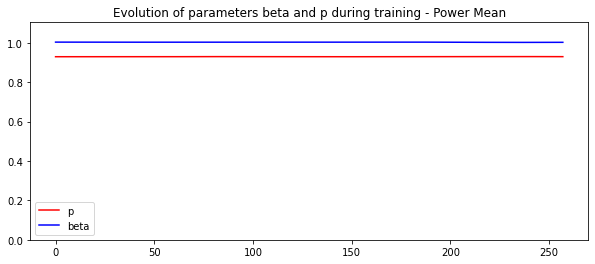

In [11]:
import matplotlib.pyplot as plt
p_epoch    = np.array([batch["p"] for batch in epoch_values]).flatten()
beta_epoch = np.array([batch["beta"] for batch in epoch_values]).flatten() 

plt.figure(figsize=(10,4))
plt.title("Evolution of parameters beta and p during training - Power Mean")
plt.plot(p_epoch, "r-", label="p")
plt.plot(beta_epoch, "b-", label="beta")
plt.ylim(0, 1.1*np.amax(np.maximum(p_epoch, beta_epoch)))
plt.legend()
plt.show()